# Clear Memory, set working directory, load packages

In [1]:
rm(list=ls())
gc()
setwd("/mnt/Data_8TB/Carolina_data/Cell_paper/")
getwd()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,636862,34.1,1411237,75.4,1085459,58.0
Vcells,1181812,9.1,8388608,64.0,1815676,13.9


[1] "/mnt/Data_8TB/Carolina_data/Cell_paper"

In [2]:
library(tidyverse) # metapackage of all tidyverse packages
library(clusterProfiler) # for GO analysis
library(org.Mm.eg.db) # for mouse gene annotation
library(org.Hs.eg.db) # for human gene annotation
library(ComplexHeatmap) # for heatmaps
library(paletteer) # for color palettes
library(openxlsx) # for writing excel files
library(limma) # for differential expression analysis
library(ggVennDiagram) # for venn diagrams



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


clusterProfiler v4.8.1  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:purrr’:

    simplify

# Load data and perform Limma analysis

In [3]:
# Load data
data <- read.xlsx("./LIMMA_Ventricule.xlsx") 
data <- data[-c(1:3),] # remove first 3 rows
colnames(data) <- data[1,] # make first row as column names
data <- data[-1,] # remove first row 
data$gene[is.na(data$gene)] <- paste0("NA_", data$protein[is.na(data$gene)]) # replace NA with protein name
data$gene[is.na(data$gene)] # check if NA is replaced
data$gene <- make.unique(data$gene, sep = "_") # make gene names unique 
rownames(data) <- data$gene # make gene names as row names
data[,2:10] <- data[,2:10] %>%  
    mutate_all(as.numeric) # convert all columns to numeric
data[,12] <- data[,12] %>%  
   as.numeric # convert p-value column to numeric
# take mean of KO2 and KO4

data$KO_2_4 <- apply(data[,colnames(data) %in% c("KO2","KO4")], 1, mean) # take mean of KO2 and KO4
data$KO_3_5 <- apply(data[,colnames(data) %in% c("KO3","KO5")], 1, mean) # take mean of KO3 and KO5 
# replace the KO2 with mean of the technical replicates of KO2 and KO4
data$KO2 <- data$KO_2_4 
# replace the KO3 with mean of the technical replicates of KO3 and KO5
data$KO3 <- data$KO_3_5 

# remove KO4 and KO5
data <- data[,!colnames(data) %in% c("KO4","KO5")] 
# remove KO_2_4 and KO_3_5
data <- data[,!colnames(data) %in% c("KO_2_4","KO_3_5")]
head(data)


character(0)

,protein,KO1,KO2,KO3,WT1,WT2,WT3,NOP,gene,limma_WT-KO
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
ece2b,A0A024B5K5,-1.1941835,-0.2506414,-1.70543961,-2.03512879,0.2338551,-0.1437395,1,ece2b,0.57187562
plxna3,A0A0A0MPG5,-0.6901571,-0.3534482,-1.22659009,1.29660601,-1.0030470,-1.1670465,2,plxna3,0.45705466
fscn1b,A0A0A0MPL5,2.0097387,-0.5939624,0.04846747,-1.15162119,-1.7366124,-0.1583802,2,fscn1b,0.11124752
si:ch211-22k7.9,A0A0A0MPR3,0.6794696,-0.7174569,-0.17531474,-1.50924571,0.8886631,-0.4942965,1,si:ch211-22k7.9,0.85742384
aasdh,A0A0A0MPS9,-3.1809933,1.2959482,-2.96366964,-0.05643476,-0.8573626,5.3906215,1,aasdh,0.14289964
ewsr1a,A0A0B4J1A5,-0.8354951,0.5101992,-0.18884247,-1.62514144,-2.4937632,-0.2870502,1,ewsr1a,0.03263861


In [4]:
data_selected <- data[,c(2:7)] # select only the columns with protein expression values
# convert each column to numeric
data_selected <- data_selected %>% 
    mutate_at(c(1:6), as.numeric) 
data_selected <- as.matrix(data_selected) # convert to matrix
head(data_selected)

,KO1,KO2,KO3,WT1,WT2,WT3
ece2b,-1.1941835,-0.2506414,-1.70543961,-2.03512879,0.2338551,-0.1437395
plxna3,-0.6901571,-0.3534482,-1.22659009,1.29660601,-1.0030470,-1.1670465
fscn1b,2.0097387,-0.5939624,0.04846747,-1.15162119,-1.7366124,-0.1583802
si:ch211-22k7.9,0.6794696,-0.7174569,-0.17531474,-1.50924571,0.8886631,-0.4942965
aasdh,-3.1809933,1.2959482,-2.96366964,-0.05643476,-0.8573626,5.3906215
ewsr1a,-0.8354951,0.5101992,-0.18884247,-1.62514144,-2.4937632,-0.2870502


In [5]:
metadata <- data.frame(samples = colnames(data_selected), 
                       group = c(rep("KO", 3), rep("WT", 3))) # create metadata
metadata

samples,group
<chr>,<chr>
KO1,KO
KO2,KO
KO3,KO
WT1,WT
WT2,WT
WT3,WT


In [6]:
# perform limma analysis between scaf and wt to get p-values
library(limma)
design <- model.matrix(~0+metadata$group) # create design matrix
colnames(design) <- c("KO", "WT") # name the columns of design matrix
design
fit <- lmFit(data_selected, design)
fit  %>% head


,KO,WT
1,1,0
2,1,0
3,1,0
4,0,1
5,0,1
6,0,1


An object of class "MArrayLM"
$coefficients
                         KO         WT
ece2b           -1.05008817 -0.6483377
plxna3          -0.75673181 -0.2911625
fscn1b           0.48808127 -1.0155379
si:ch211-22k7.9 -0.07110069 -0.3716264
aasdh           -1.61623825  1.4922747
ewsr1a          -0.17137945 -1.4686516

$rank
[1] 2

$assign
[1] 1 1

$qr
$qr
          KO         WT
1 -1.7320508  0.0000000
2  0.5773503 -1.7320508
3  0.5773503  0.0000000
4  0.0000000  0.5773503
5  0.0000000  0.5773503
6  0.0000000  0.5773503
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$`metadata$group`
[1] "contr.treatment"


$qraux
[1] 1.57735 1.00000

$pivot
[1] 1 2

$tol
[1] 1e-07

$rank
[1] 2


$df.residual
[1] 4 4 4 4 4 4

$sigma
          ece2b          plxna3          fscn1b si:ch211-22k7.9           aasdh 
      1.0056636       1.0225945       1.1127339       0.9860968       2.9942137 
         ewsr1a 
      0.9188891 

$cov.coefficients
          KO        WT
KO 0.3333333 0.0000000
W

In [7]:
# "Adult_KO", "Adult_WT"
cont_matrix <- makeContrasts( # create contrast matrix
ko_vs_wt=KO-WT,
levels=design)
cont_matrix
fit2 <- contrasts.fit(fit, cont_matrix)
fit2 <- eBayes(fit2)
# fit2

,ko_vs_wt
KO,1
WT,-1


In [9]:
ko_vs_wt <- topTable(fit2, coef = 1, adjust.method = "BH", sort.by = "p", number = Inf)  # get the differentially expressed genes
ko_vs_wt <- ko_vs_wt %>% dplyr::select(logFC, P.Value, adj.P.Val) # select only the columns of interest
colnames(ko_vs_wt) <- paste0("ko_vs_wt_",colnames(ko_vs_wt)) # rename the columns
ko_vs_wt <- ko_vs_wt %>% rownames_to_column("gene") # make gene names as a column
ko_vs_wt %>% head # check the data


,gene,ko_vs_wt_logFC,ko_vs_wt_P.Value,ko_vs_wt_adj.P.Val
,<chr>,<dbl>,<dbl>,<dbl>
1,ndufa4a,-7.513439,1.147101e-05,0.0483962
2,cox5ab,-3.924994,2.120659e-04,0.3256911
3,twf2,3.580944,3.250880e-04,0.3256911
4,bloc1s6,-4.260404,4.055141e-04,0.3256911
5,ank2b_1,3.590296,5.255563e-04,0.3256911
6,prdx6,-3.553210,6.231779e-04,0.3256911


In [10]:
# merge data, ko_vs_wtby column gene
data_merged <- Reduce(function(x, y) merge(x, y, by = "gene", all = TRUE), list(data,ko_vs_wt))
data_merged <- data_merged %>% dplyr::select(-contains("limma"))
# remove _* from gene column
data_merged$gene <- gsub("_.", "", data_merged$gene)
data_merged %>% head

[1] 4219   12

[1] 4219    4

,gene,protein,KO1,KO2,KO3,WT1,WT2,WT3,NOP,ko_vs_wt_logFC,ko_vs_wt_P.Value,ko_vs_wt_adj.P.Val
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,44986,A0A2R8PWS6,0.1545013,0.94989998,0.1845100,0.2563195,0.2193404,1.24941529,3,-0.14538795,0.7983911,0.9649545
2,45171,F1QW60,-0.6527151,0.19627087,-0.2632826,-0.3947994,0.7537580,0.09811806,10,-0.39226783,0.4928521,0.8733066
3,45175,F1R3Q3,-0.4547053,-0.11640637,-0.1106835,0.3867737,-0.4108361,-0.11908362,9,-0.17954972,0.7236547,0.9479193
4,45179,Q568B3,0.3430870,0.62495576,0.5810429,-0.8501196,-0.1761369,0.05073808,4,0.84153468,0.1318171,0.7207413
5,45184,A0JMF4,2.3908417,0.04751272,0.9208836,1.5454670,1.6800118,-0.01409808,2,0.04928575,0.9517309,0.9922923
6,a2ml,F6NTZ9,0.1247026,-0.62873965,-2.2726963,4.7372387,-2.6636864,-2.77352423,6,-0.69225378,0.7342710,0.9491966


In [34]:
write.csv(data_merged, file = "./LIMMA_Ventricle_logfc_technical_averaged.csv", row.names = FALSE) # write the data to a csv file

# Pathway Analysis

## Overrepresentation Analysis

In [13]:
# Function to convert zebrafish gene names to mouse gene names
convertDanioGeneList_Mouse <- function(x){ 
  require("biomaRt") # load biomaRt package
  mouse = useEnsembl("ensembl", dataset = "mmusculus_gene_ensembl", host = "https://dec2021.archive.ensembl.org") # use human mart
  danio = useEnsembl("ensembl", dataset = "drerio_gene_ensembl", host = "https://dec2021.archive.ensembl.org") # use zebrafish mart
  
  genesV2 = getLDS(attributes = c("ensembl_gene_id", "zfin_id_symbol"), 
                  filters = "zfin_id_symbol", # get zebrafish gene names
                  values = x , # use the zebrafish gene names
                  mart = danio,  # use the zebrafish mart
                  attributesL = c("mgi_symbol", "ensembl_gene_id", "description"), # get human gene names
                  martL = mouse, uniqueRows=T) # use the human mart
  
  colnames(genesV2)[colnames(genesV2)== "Gene.stable.ID"] <- "EnsmblID_Zebrafish" # rename columns
  colnames(genesV2)[colnames(genesV2)== "Gene.stable.ID.1"] <- "EnsmblID_Mouse" # rename columns
  
  # Print the first 6 genes found to the screen
  print(head(genesV2))
  return(genesV2) # return the genes
}


In [9]:
# Function for GO analysis
GO_function <- function(gene_list, pval  = 0.05, onto= "MF", prefix="", org="mouse"){
library(clusterProfiler) # for GO analysis
library(org.Mm.eg.db) # for mouse gene annotation
library(org.Hs.eg.db) # for human gene annotation
library(ReactomePA) # for reactome pathway analysis
if(org=="mouse"){ # check if mouse
    orgdb <- "org.Mm.eg.db" # use mouse gene annotation
    org_reactome <- "mouse" # use mouse for reactome pathway analysis
}else if(org=="human"){ # check if human
    orgdb <- "org.Hs.eg.db" # use human gene annotation 
    org_reactome <- "human"# use human for reactome pathway analysis
}else{
    message("Please enter a valid organism (mouse or human)") # print error message
}

    if(onto %in% c("MF", "CC", "BP")){    
    compGO <- enrichGO(gene = gene_list, pvalueCutoff  = pval,keyType = "SYMBOL",
                             pAdjustMethod = "BH",OrgDb = orgdb, ont = onto)
    }else if(onto=="reactome"){ # check if reactome
        gene_list <- bitr(gene_list, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = orgdb)
        gene_list <- gene_list$ENTREZID
        compGO <- enrichPathway(gene = gene_list, pvalueCutoff  = 0.05, organism= org_reactome,      readable = TRUE)
    
    }else{
        message("Please enter a valid GO term")
    }

      
    
    if(is.null(compGO)){ # check if no GO terms are obtained
    message(paste0("No GO:",onto, " obtained"))
    message(paste0("****************************************************************************************"))
    message(paste0("\n"))
   
    }else { # if GO terms are obtained
        compGO_df <- as.data.frame(compGO) # convert to dataframe
        compGO_df$GeneRatio_decimal <- compGO_df$GeneRatio # convert GeneRatio to decimal
        compGO_df$GeneRatio_decimal <- sapply(compGO_df$GeneRatio_decimal,  
                                                      function(x) (eval(parse(text = as.character(x))))) # convert GeneRatio to decimal
        compGO_df$BgRatio_decimal <- compGO_df$BgRatio #    convert BgRatio to decimal
        compGO_df$BgRatio_decimal <- sapply(compGO_df$BgRatio_decimal,  # convert BgRatio to decimal
                                                      function(x) (eval(parse(text = as.character(x)))))
                                                    
        compGO_df <- compGO_df %>% tidyr::separate_rows(geneID, sep = "/", convert = FALSE) %>%
          arrange(desc(GeneRatio_decimal)) # separate geneID column into multiple rows and arrange in descending order
        compGO_df %>% head  

            if(nrow(compGO_df)==0){
            message(paste0("No GP:",onto, " obtained"))
            message(paste0("****************************************************************************************"))
            message(paste0("\n"))

            } else{

            write.csv(compGO_df, paste0(prefix,"_GO_",onto, "_pathways.csv"))


            full_name= switch(onto,
                    MF= "Moleuclar Function",
                    CC= "Cellular Components",
                    BP= "Biological Pathways",
                    reactome= "Reactome Pathways"
                             )                                           

            print(dotplot(compGO, showCategory = 15, title = paste0("GO Pathway Enrichment Analysis \n",full_name), 
                    font.size = 12))
            dev.copy(
            pdf,
            file = paste0(prefix,"_GO_",onto, "_pathways.pdf"),
            width = 10,
            height = 12
            )
            dev.off ()




        message(paste0("Pathway analysis GO:",onto, " for Cell Type : ", " done"))
        message(paste0("****************************************************************************************"))
        message(paste0("\n"))

        }
    }
}

In [15]:
ko_wt_pval05_genes_mouse <- convertDanioGeneList_Mouse(data_merged$gene[data_merged$ko_vs_wt_P.Value<=0.05]
) # convert zebrafish gene names to human gene names
head(ko_wt_pval05_genes_mouse)

Loading required package: biomaRt



  EnsmblID_Zebrafish ZFIN.symbol MGI.symbol     EnsmblID_Mouse
1 ENSDARG00000052674     csnk1a1    Csnk1a1 ENSMUSG00000024576
2 ENSDARG00000076393      tmem65     Tmem65 ENSMUSG00000062373
3 ENSDARG00000093945       vma21      Vma21 ENSMUSG00000073131
4 ENSDARG00000016319          c9         C9 ENSMUSG00000022149
5 ENSDARG00000019332      ndufb4     Ndufb4 ENSMUSG00000022820
6 ENSDARG00000040712       adprh      Adprh ENSMUSG00000002844
                                                                      Gene.description
1                         casein kinase 1, alpha 1 [Source:MGI Symbol;Acc:MGI:1934950]
2                         transmembrane protein 65 [Source:MGI Symbol;Acc:MGI:1922118]
3 VMA21 vacuolar H+-ATPase homolog (S. cerevisiae) [Source:MGI Symbol;Acc:MGI:1914298]
4                           complement component 9 [Source:MGI Symbol;Acc:MGI:1098282]
5        NADH:ubiquinone oxidoreductase subunit B4 [Source:MGI Symbol;Acc:MGI:1915444]
6                    ADP-ribosylargin

,EnsmblID_Zebrafish,ZFIN.symbol,MGI.symbol,EnsmblID_Mouse,Gene.description
,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSDARG00000052674,csnk1a1,Csnk1a1,ENSMUSG00000024576,"casein kinase 1, alpha 1 [Source:MGI Symbol;Acc:MGI:1934950]"
2,ENSDARG00000076393,tmem65,Tmem65,ENSMUSG00000062373,transmembrane protein 65 [Source:MGI Symbol;Acc:MGI:1922118]
3,ENSDARG00000093945,vma21,Vma21,ENSMUSG00000073131,VMA21 vacuolar H+-ATPase homolog (S. cerevisiae) [Source:MGI Symbol;Acc:MGI:1914298]
4,ENSDARG00000016319,c9,C9,ENSMUSG00000022149,complement component 9 [Source:MGI Symbol;Acc:MGI:1098282]
5,ENSDARG00000019332,ndufb4,Ndufb4,ENSMUSG00000022820,NADH:ubiquinone oxidoreductase subunit B4 [Source:MGI Symbol;Acc:MGI:1915444]
6,ENSDARG00000040712,adprh,Adprh,ENSMUSG00000002844,ADP-ribosylarginine hydrolase [Source:MGI Symbol;Acc:MGI:1098234]


In [ ]:
# write an excel sheet with one sheet for up genes, down genes, and all genes
write.xlsx(list("adult_ko_vs_adult_wt_up"= adult_ko_vs_adult_wt_up, 
"adult_ko_vs_adult_wt_down"=adult_ko_vs_adult_wt_down,
"adult_ko_vs_adult_wt_all"=adult_ko_vs_adult_wt_all

),
           file = "./LIMMA_Muscle_logfc_up_down_PA_adult_wt_adult_ko.xlsx", append = TRUE)


In [16]:
getwd()

[1] "/mnt/Data_8TB/Carolina_data/Cell_paper"

Warning message in dir.create("./proteomics_n_3_ventricle_technical_avg/GO_analysis/Moleuclar_Function", :
“'./proteomics_n_3_ventricle_technical_avg/GO_analysis/Moleuclar_Function' already exists”
Warning message in dir.create("./proteomics_n_3_ventricle_technical_avg/GO_analysis/Cellular_Components", :
“'./proteomics_n_3_ventricle_technical_avg/GO_analysis/Cellular_Components' already exists”
Warning message in dir.create("./proteomics_n_3_ventricle_technical_avg/GO_analysis/Biological_Process", :
“'./proteomics_n_3_ventricle_technical_avg/GO_analysis/Biological_Process' already exists”
Warning message in dir.create("./proteomics_n_3_ventricle_technical_avg/GO_analysis/Reactome", :
“'./proteomics_n_3_ventricle_technical_avg/GO_analysis/Reactome' already exists”
ReactomePA v1.44.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use ReactomePA in published research, please cite:
Guangchuang Yu, Qing-Yu He. ReactomePA: an R/Bioconductor package for reactome pa

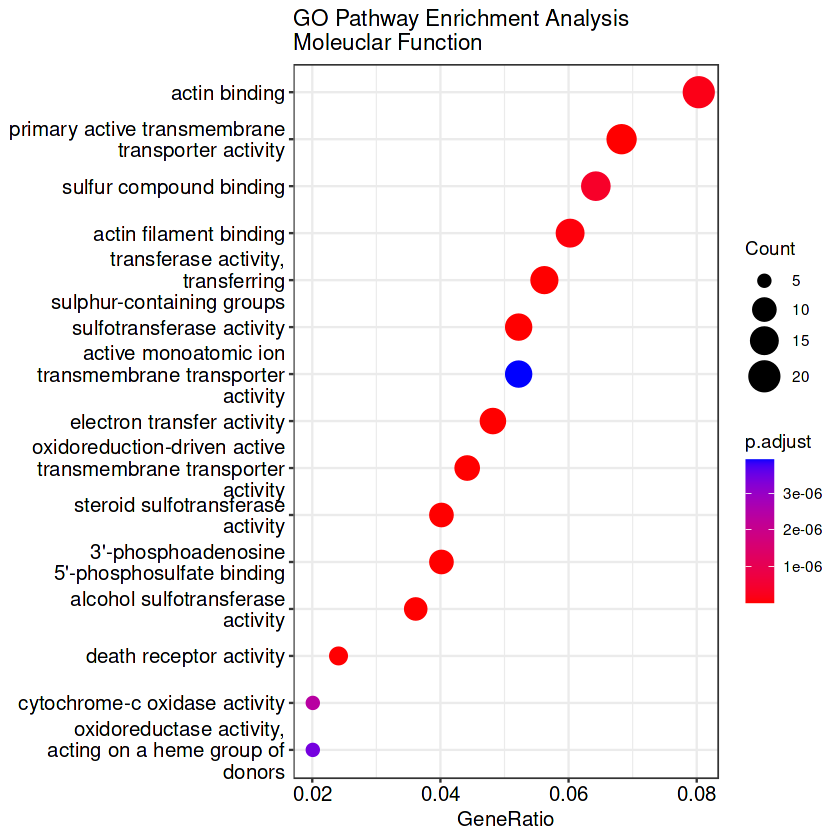

Pathway analysis GO:BP for Cell Type :  done

****************************************************************************************






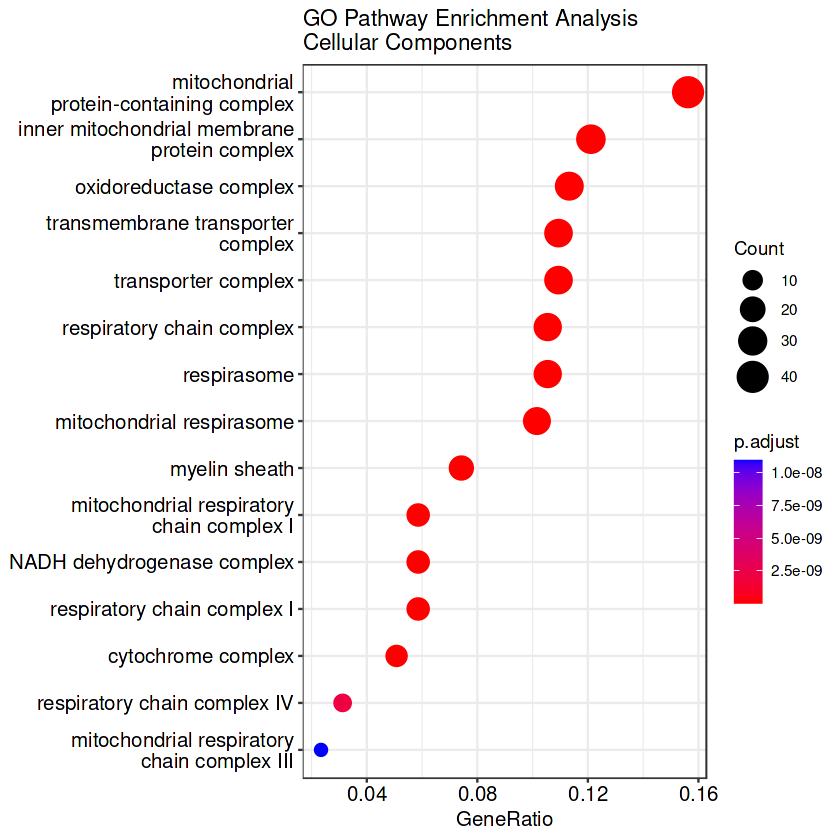

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(gene_list, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = orgdb):
“1.14% of input gene IDs are fail to map...”
Pathway analysis GO:reactome for Cell Type :  done

****************************************************************************************






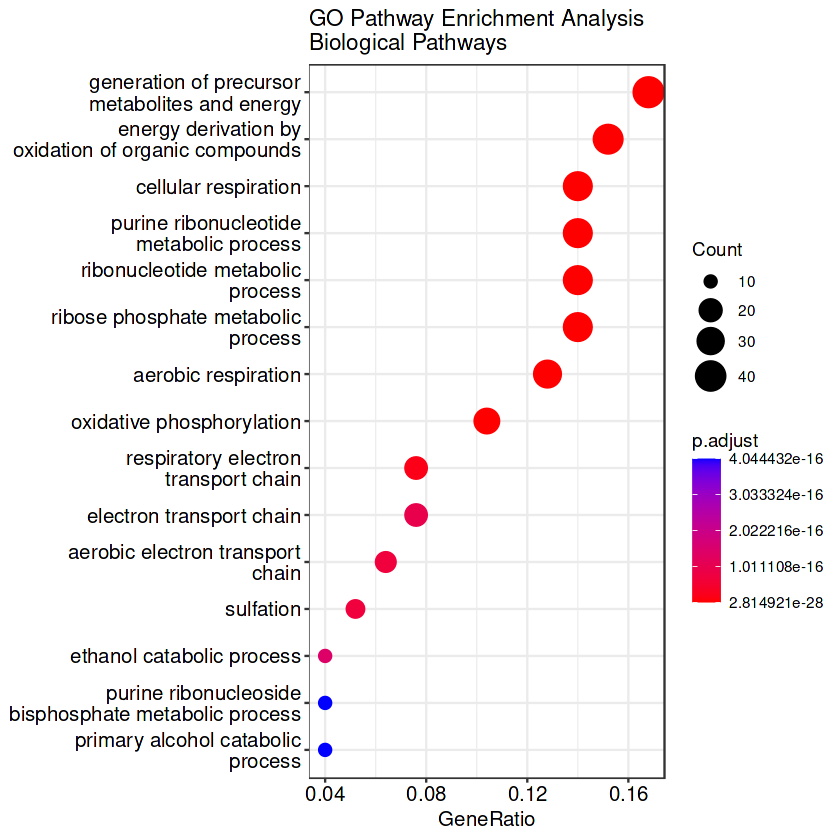

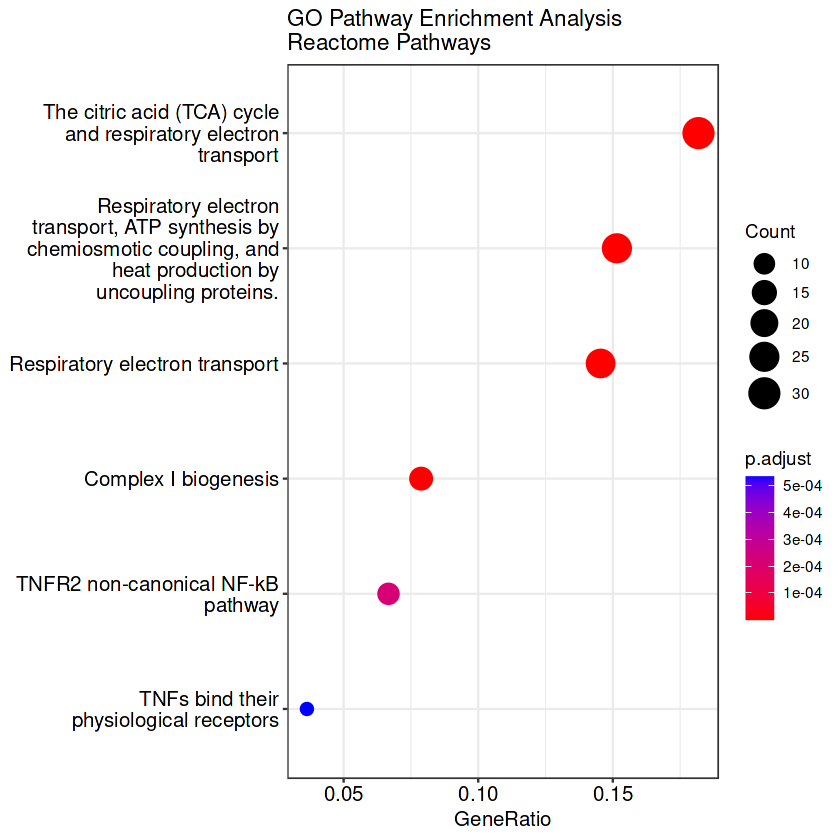

In [17]:
 # perform GO analysis for all genes
dir.create("./proteomics_n_3_ventricle_technical_avg/GO_analysis/Moleuclar_Function", recursive = TRUE)
dir.create("./proteomics_n_3_ventricle_technical_avg/GO_analysis/Cellular_Components", recursive = TRUE)
dir.create("./proteomics_n_3_ventricle_technical_avg/GO_analysis/Biological_Process", recursive = TRUE)
dir.create("./proteomics_n_3_ventricle_technical_avg/GO_analysis/Reactome", recursive = TRUE)

GO_function(ko_wt_pval05_genes_mouse$MGI.symbol	, pval  = 0.05, onto= "MF", prefix="./proteomics_n_3_ventricle_technical_avg/GO_analysis/Moleuclar_Function/ko_wt_pval05_", org="mouse")
GO_function(ko_wt_pval05_genes_mouse$MGI.symbol	, pval  = 0.05, onto= "CC", prefix="./proteomics_n_3_ventricle_technical_avg/GO_analysis/Cellular_Components/ko_wt_pval05_", org="mouse")
GO_function(ko_wt_pval05_genes_mouse$MGI.symbol	, pval  = 0.05, onto= "BP", prefix="./proteomics_n_3_ventricle_technical_avg/GO_analysis/Biological_Process/ko_wt_pval05_", org="mouse")
GO_function(ko_wt_pval05_genes_mouse$MGI.symbol	, pval  = 0.05, onto= "reactome", prefix="./proteomics_n_3_ventricle_technical_avg/GO_analysis/Reactome/ko_wt_pval05_", org="mouse")



In [25]:
# select genes upregulated in KO vs WT
ko_wt_pval05_up <- data_merged[data_merged$ko_vs_wt_P.Value<=0.05 & data_merged$ko_vs_wt_logFC>=0,]
ko_wt_pval05_up %>% head
ko_wt_pval05_up %>% dim

,gene,protein,KO1,KO2,KO3,WT1,WT2,WT3,NOP,ko_vs_wt_logFC,ko_vs_wt_P.Value,ko_vs_wt_adj.P.Val
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,abcb4,E7F1E3,1.7525085,1.7090815,1.978427,1.1078013,0.5348448,-0.81522116,10,1.537531,0.04058917,0.6561138
53,ace,E7FFA5,1.6871115,1.0844029,2.288098,0.3588941,-0.2542683,-0.21695543,2,1.723981,0.01411150,0.6116578
57,aco2,F8W4M7,2.5830499,7.0838927,6.014105,1.0510744,-1.5396532,2.11937458,3,4.683417,0.01012986,0.5449426
81,actbb,Q7ZVF9,0.2352243,0.6041838,1.538134,-2.3004842,-0.5111959,-0.02033702,16,1.736520,0.04963781,0.6716651
83,actc1a,Q6IQR3,0.8865733,1.3519529,2.040819,-0.1322955,0.8073278,-1.34496843,39,1.649760,0.04650388,0.6710317
87,actn4,H9GX78,1.3914703,0.6613983,1.547322,-1.3435473,-0.1823949,-0.98224993,2,2.036128,0.00732469,0.4993477


[1] 180  12

In [24]:
# select genes downregulated in KO vs WT
ko_wt_pval05_down <- data_merged[data_merged$ko_vs_wt_P.Value<=0.05 & data_merged$ko_vs_wt_logFC<=0,]
ko_wt_pval05_down %>% head
ko_wt_pval05_down %>% dim

,gene,protein,KO1,KO2,KO3,WT1,WT2,WT3,NOP,ko_vs_wt_logFC,ko_vs_wt_P.Value,ko_vs_wt_adj.P.Val
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
167,alad,A0A0R4IPV1,-1.8937150,-0.5833043,-1.4975788,0.672693,0.6583896,0.2379190,10,-1.847867,0.010699333,0.5449426
183,aldh9a1b,Q802W2,-1.0758477,-4.2714832,-5.1340732,-2.182588,1.8254340,0.7438257,6,-3.622692,0.029978213,0.6554334
328,ass1,Q66I24,-5.1539131,-13.8782872,-10.1274136,3.102007,1.6143561,-2.8702399,10,-10.335246,0.002746317,0.4138111
349,atp2a1l,A0JMP4,-0.6378300,-1.0112399,-1.0630356,1.619401,1.4437790,-0.3482483,22,-1.809012,0.026666412,0.6406443
352,atp2a3,A2BIP1,-0.2727453,-1.6609984,-0.9738952,1.283634,-0.3407920,0.8383122,2,-1.562931,0.044812340,0.6710317
356,atp5f1d,Q1LVG7,-0.8699470,-4.3085576,-2.1564179,1.304702,1.9223411,-1.5032353,3,-3.019577,0.034609695,0.6554334


[1] 132  12

In [23]:
# select all genes with p-value <=0.05
ko_wt_pval05_all <- data_merged[data_merged$ko_vs_wt_P.Value<=0.05,]
ko_wt_pval05_all %>% head

,gene,protein,KO1,KO2,KO3,WT1,WT2,WT3,NOP,ko_vs_wt_logFC,ko_vs_wt_P.Value,ko_vs_wt_adj.P.Val
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,abcb4,E7F1E3,1.7525085,1.7090815,1.978427,1.1078013,0.5348448,-0.81522116,10,1.537531,0.04058917,0.6561138
53,ace,E7FFA5,1.6871115,1.0844029,2.288098,0.3588941,-0.2542683,-0.21695543,2,1.723981,0.01411150,0.6116578
57,aco2,F8W4M7,2.5830499,7.0838927,6.014105,1.0510744,-1.5396532,2.11937458,3,4.683417,0.01012986,0.5449426
81,actbb,Q7ZVF9,0.2352243,0.6041838,1.538134,-2.3004842,-0.5111959,-0.02033702,16,1.736520,0.04963781,0.6716651
83,actc1a,Q6IQR3,0.8865733,1.3519529,2.040819,-0.1322955,0.8073278,-1.34496843,39,1.649760,0.04650388,0.6710317
87,actn4,H9GX78,1.3914703,0.6613983,1.547322,-1.3435473,-0.1823949,-0.98224993,2,2.036128,0.00732469,0.4993477


In [26]:
# write an excel sheet with one sheet for up genes, down genes, and all genes
write.xlsx(list("ko_vs_wt_up"= ko_wt_pval05_up, 
"ko_vs_wt_down"=ko_wt_pval05_down,
"ko_vs_wt_all"=ko_wt_pval05_all

),
           file = "./LIMMA_Ventricle_techniocal_avg_logfc_up_down_PA_ko_wt.xlsx", append = TRUE)


In [14]:
# convert zebrafish gene names to mouse gene names for up genes
ko_wt_pval05_up_mouse <- convertDanioGeneList_Mouse(data_merged$gene[data_merged$ko_vs_wt_P.Value<=0.05 & 
data_merged$ko_vs_wt_logFC>=0])
head(ko_wt_pval05_up_mouse)

  EnsmblID_Zebrafish ZFIN.symbol MGI.symbol     EnsmblID_Mouse
1 ENSDARG00000041314      ndufb9     Ndufb9 ENSMUSG00000022354
2 ENSDARG00000093945       vma21      Vma21 ENSMUSG00000073131
3 ENSDARG00000019332      ndufb4     Ndufb4 ENSMUSG00000022820
4 ENSDARG00000052674     csnk1a1    Csnk1a1 ENSMUSG00000024576
5 ENSDARG00000040712       adprh      Adprh ENSMUSG00000002844
6 ENSDARG00000038978      dnajb4     Dnajb4 ENSMUSG00000028035
                                                                      Gene.description
1        NADH:ubiquinone oxidoreductase subunit B9 [Source:MGI Symbol;Acc:MGI:1913468]
2 VMA21 vacuolar H+-ATPase homolog (S. cerevisiae) [Source:MGI Symbol;Acc:MGI:1914298]
3        NADH:ubiquinone oxidoreductase subunit B4 [Source:MGI Symbol;Acc:MGI:1915444]
4                         casein kinase 1, alpha 1 [Source:MGI Symbol;Acc:MGI:1934950]
5                    ADP-ribosylarginine hydrolase [Source:MGI Symbol;Acc:MGI:1098234]
6 DnaJ heat shock protein family (Hsp

,EnsmblID_Zebrafish,ZFIN.symbol,MGI.symbol,EnsmblID_Mouse,Gene.description
,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSDARG00000041314,ndufb9,Ndufb9,ENSMUSG00000022354,NADH:ubiquinone oxidoreductase subunit B9 [Source:MGI Symbol;Acc:MGI:1913468]
2,ENSDARG00000093945,vma21,Vma21,ENSMUSG00000073131,VMA21 vacuolar H+-ATPase homolog (S. cerevisiae) [Source:MGI Symbol;Acc:MGI:1914298]
3,ENSDARG00000019332,ndufb4,Ndufb4,ENSMUSG00000022820,NADH:ubiquinone oxidoreductase subunit B4 [Source:MGI Symbol;Acc:MGI:1915444]
4,ENSDARG00000052674,csnk1a1,Csnk1a1,ENSMUSG00000024576,"casein kinase 1, alpha 1 [Source:MGI Symbol;Acc:MGI:1934950]"
5,ENSDARG00000040712,adprh,Adprh,ENSMUSG00000002844,ADP-ribosylarginine hydrolase [Source:MGI Symbol;Acc:MGI:1098234]
6,ENSDARG00000038978,dnajb4,Dnajb4,ENSMUSG00000028035,DnaJ heat shock protein family (Hsp40) member B4 [Source:MGI Symbol;Acc:MGI:1914285]


In [15]:
# convert zebrafish gene names to mouse gene names for down genes
ko_wt_pval05_down_mouse <- convertDanioGeneList_Mouse(data_merged$gene[data_merged$ko_vs_wt_P.Value<=0.05 & data_merged$ko_vs_wt_logFC<0]

)
head(ko_wt_pval05_down_mouse)

  EnsmblID_Zebrafish ZFIN.symbol MGI.symbol     EnsmblID_Mouse
1 ENSDARG00000016319          c9         C9 ENSMUSG00000022149
2 ENSDARG00000042172         c7a         C7 ENSMUSG00000079105
3 ENSDARG00000076393      tmem65     Tmem65 ENSMUSG00000062373
4 ENSDARG00000009341        nrap       Nrap ENSMUSG00000049134
5 ENSDARG00000101318    pcdh2ab9    Pcdhac2 ENSMUSG00000102697
6 ENSDARG00000044132        ogna        Ogn ENSMUSG00000021390
                                                        Gene.description
1             complement component 9 [Source:MGI Symbol;Acc:MGI:1098282]
2               complement component 7 [Source:MGI Symbol;Acc:MGI:88235]
3           transmembrane protein 65 [Source:MGI Symbol;Acc:MGI:1922118]
4  nebulin-related anchoring protein [Source:MGI Symbol;Acc:MGI:1098765]
5 protocadherin alpha subfamily C, 2 [Source:MGI Symbol;Acc:MGI:1891443]
6                         osteoglycin [Source:MGI Symbol;Acc:MGI:109278]


,EnsmblID_Zebrafish,ZFIN.symbol,MGI.symbol,EnsmblID_Mouse,Gene.description
,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSDARG00000016319,c9,C9,ENSMUSG00000022149,complement component 9 [Source:MGI Symbol;Acc:MGI:1098282]
2,ENSDARG00000042172,c7a,C7,ENSMUSG00000079105,complement component 7 [Source:MGI Symbol;Acc:MGI:88235]
3,ENSDARG00000076393,tmem65,Tmem65,ENSMUSG00000062373,transmembrane protein 65 [Source:MGI Symbol;Acc:MGI:1922118]
4,ENSDARG00000009341,nrap,Nrap,ENSMUSG00000049134,nebulin-related anchoring protein [Source:MGI Symbol;Acc:MGI:1098765]
5,ENSDARG00000101318,pcdh2ab9,Pcdhac2,ENSMUSG00000102697,"protocadherin alpha subfamily C, 2 [Source:MGI Symbol;Acc:MGI:1891443]"
6,ENSDARG00000044132,ogna,Ogn,ENSMUSG00000021390,osteoglycin [Source:MGI Symbol;Acc:MGI:109278]


In [ ]:
# perform GO analysis for up genes
dir.create("./proteomics_n_3_ventricle_technical_avg/GO_Analysis/up_pval05/Molecular_Function", recursive = TRUE)
dir.create("./proteomics_n_3_ventricle_technical_avg/GO_Analysis/up_pval05/Cellular_Component", recursive = TRUE)
dir.create("./proteomics_n_3_ventricle_technical_avg/GO_Analysis/up_pval05/Biological_Process", recursive = TRUE)
dir.create("./proteomics_n_3_ventricle_technical_avg/GO_Analysis/up_pval05/Reactome", recursive = TRUE)

GO_function(ko_wt_pval05_up_mouse$MGI.symbol, pval  = 0.05, onto= "MF", prefix="./proteomics_n_3_ventricle_technical_avg/GO_Analysis/up_pval05/Molecular_Function/ko_wt_pval05_up", org="mouse")
GO_function(ko_wt_pval05_up_mouse$MGI.symbol, pval  = 0.05, onto= "CC", prefix="./proteomics_n_3_ventricle_technical_avg/GO_Analysis/up_pval05/Cellular_Component/ko_wt_pval05_up", org="mouse")
GO_function(ko_wt_pval05_up_mouse$MGI.symbol, pval  = 0.05, onto= "BP", prefix="./proteomics_n_3_ventricle_technical_avg/GO_Analysis/up_pval05/Biological_Process/ko_wt_pval05_up", org="mouse")
GO_function(ko_wt_pval05_up_mouse$MGI.symbol, pval  = 0.05, onto= "reactome", prefix="./proteomics_n_3_ventricle_technical_avg/GO_Analysis/up_pval05/Reactome/ko_wt_pval05_up", org="mouse")


# perform GO analysis for down genes
dir.create("./proteomics_n_3_ventricle_technical_avg/GO_Analysis/down_pval05/Molecular_Function", recursive = TRUE)
dir.create("./proteomics_n_3_ventricle_technical_avg/GO_Analysis/down_pval05/Cellular_Component", recursive = TRUE)
dir.create("./proteomics_n_3_ventricle_technical_avg/GO_Analysis/down_pval05/Biological_Process", recursive = TRUE)
dir.create("./proteomics_n_3_ventricle_technical_avg/GO_Analysis/down_pval05/Reactome", recursive = TRUE)

GO_function(ko_wt_pval05_down_mouse$MGI.symbol, pval  = 0.05, onto= "MF", prefix="./proteomics_n_3_ventricle_technical_avg/GO_Analysis/down_pval05/Molecular_Function/ko_wt_pval05_down", org="mouse")
GO_function(ko_wt_pval05_down_mouse$MGI.symbol, pval  = 0.05, onto= "CC", prefix="./proteomics_n_3_ventricle_technical_avg/GO_Analysis/down_pval05/Cellular_Component/ko_wt_pval05_down", org="mouse")
GO_function(ko_wt_pval05_down_mouse$MGI.symbol, pval  = 0.05, onto= "BP", prefix="./proteomics_n_3_ventricle_technical_avg/GO_Analysis/down_pval05/Biological_Process/ko_wt_pval05_down", org="mouse")
GO_function(ko_wt_pval05_down_mouse$MGI.symbol, pval  = 0.05, onto= "reactome", prefix="./proteomics_n_3_ventricle_technical_avg/GO_Analysis/down_pval05/Reactome/ko_wt_pval05_down", org="mouse")


# perform GO analysis for all genes
dir.create("./proteomics_n_3_ventricle_technical_avg/GO_Analysis/all_pval05/Molecular_Function", recursive = TRUE)
dir.create("./proteomics_n_3_ventricle_technical_avg/GO_Analysis/all_pval05/Cellular_Component", recursive = TRUE)
dir.create("./proteomics_n_3_ventricle_technical_avg/GO_Analysis/all_pval05/Biological_Process", recursive = TRUE)
dir.create("./proteomics_n_3_ventricle_technical_avg/GO_Analysis/all_pval05/Reactome", recursive = TRUE)


GO_function(ko_wt_pval05_genes_mouse$MGI.symbol, pval  = 0.05, onto= "MF", prefix="./proteomics_n_3_ventricle_technical_avg/GO_Analysis/all_pval05/Molecular_Function/ko_wt_pval05_all", org="mouse")
GO_function(ko_wt_pval05_genes_mouse$MGI.symbol, pval  = 0.05, onto= "CC", prefix="./proteomics_n_3_ventricle_technical_avg/GO_Analysis/all_pval05/Cellular_Component/ko_wt_pval05_all", org="mouse")
GO_function(ko_wt_pval05_genes_mouse$MGI.symbol, pval  = 0.05, onto= "BP", prefix="./proteomics_n_3_ventricle_technical_avg/GO_Analysis/all_pval05/Biological_Process/ko_wt_pval05_all", org="mouse")
GO_function(ko_wt_pval05_genes_mouse$MGI.symbol, pval  = 0.05, onto= "reactome", prefix="./proteomics_n_3_ventricle_technical_avg/GO_Analysis/all_pval05/Reactome/ko_wt_pval05_all", org="mouse")





## GSEA

In [ ]:
GSEA_function <- function(df, pval_deg  = 0.05,pval_enrich=0.2, onto= "MF", prefix=""){
    
    gene_list_df <- df[df$ko_vs_wt_P.Value<=pval_deg,]
    gene_list_df <- gene_list_df %>% arrange(desc(ko_vs_wt_logFC))
    gene_list_df <- gene_list_df[!is.na(gene_list_df$gene_mouse),]
    gene_list_df <- gene_list_df[!duplicated(gene_list_df$gene_mouse),]
    gene_list <- gene_list_df %>% pull(ko_vs_wt_logFC)
    names(gene_list) <- gene_list_df %>% pull(gene_mouse)

    gene_list <- gene_list[!duplicated(gene_list)]
    print(head(gene_list)) 



    compGO <- gseGO(gene = gene_list, pvalueCutoff  = pval_enrich,,keyType = "SYMBOL",
                             pAdjustMethod = "BH",OrgDb = "org.Mm.eg.db", ont = onto)
    # print(compGO)
    if(is.null(compGO)|nrow(compGO@result)==0){
    message(paste0("No GSEA:",onto))
    message(paste0("****************************************************************************************"))
    message(paste0("\n"))
   
    }else {

        compGO_df <- as.data.frame(compGO)
          compGO_df <- compGO_df %>% tidyr::separate_rows(core_enrichment, sep = "/", convert = FALSE) %>%  arrange((p.adjust))

            if(nrow(compGO_df)==0){
            message(paste0("No GSEA:",onto))
            message(paste0("****************************************************************************************"))
            message(paste0("\n"))

            } else{

            write.csv(compGO_df, paste0(prefix,"_GSEA_",onto, "_pathways.csv"))


            full_name= switch(onto,
                    MF= "Moleuclar Function",
                    CC= "Cellular Components",
                    BP= "Biological Processes"
                             )                                           
            print(paste(full_name, onto))
            print(dotplot(compGO, showCategory = 15, title = paste0("DEG GO Pathway Enrichment Analysis \n",full_name ), 
                    font.size = 12) + facet_grid(.~.sign))
            dev.copy(
            pdf,
            file = paste0(prefix,"_GSEA_",onto, "_pathways.pdf"),
            width = 10,
            height = 8
            )
            dev.off ()




        message(paste0("DEG Pathway analysis GO:",onto, " done"))
        message(paste0("****************************************************************************************"))
        message(paste0("\n"))

        }
    }
}



In [ ]:
description_df_mouse_zf %>% colnames()

[1] "gene"                             "gene_mouse"                      
 [3] "protein"                          "KO1"                             
 [5] "KO2"                              "KO3"                             
 [7] "WT1"                              "WT2"                             
 [9] "WT3"                              "NOP"                             
[11] "ko_vs_wt_logFC"                   "ko_vs_wt_P.Value"                
[13] "ko_vs_wt_adj.P.Val"               "gene_full_name_zf"               
[15] "GO_description_zf"                "associated_phenotype_zf"         
[17] "GO_name_zf"                       "GO_family_zf"                    
[19] "gene_full_name_mouse"             "GO_description_mouse"            
[21] "associated_phenotype_mouse"       "GO_name_mouse"                   
[23] "GO_family_mouse"                  "Description"                     
[25] "MitoCarta3.0_SubMitoLocalization" "MitoCarta3.0_MitoPathways"       
[27] "confirmation_status_muscle"       "confirmation_status_ventricle"   
[29] "info_genecards_uniprot_nadia"

   Usp38    Ywhab  Pcdhac2   Rnf123    Ift74    Decr1 
8.898706 8.111737 7.996985 7.558226 7.435486 7.346143 


preparing geneSet collections...

GSEA analysis...

no term enriched under specific pvalueCutoff...

No GSEA:MF

****************************************************************************************






   Usp38    Ywhab  Pcdhac2   Rnf123    Ift74    Decr1 
8.898706 8.111737 7.996985 7.558226 7.435486 7.346143 


preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...



[1] "Cellular Components CC"


DEG Pathway analysis GO:CC done

****************************************************************************************






   Usp38    Ywhab  Pcdhac2   Rnf123    Ift74    Decr1 
8.898706 8.111737 7.996985 7.558226 7.435486 7.346143 


preparing geneSet collections...

GSEA analysis...

no term enriched under specific pvalueCutoff...

No GSEA:BP

****************************************************************************************






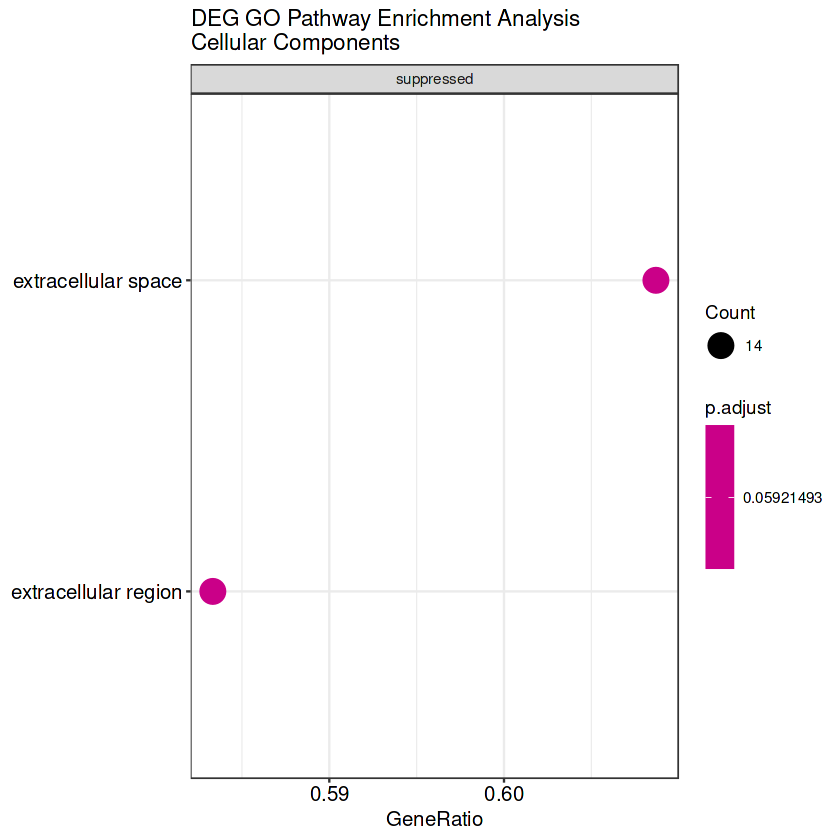

In [ ]:


dir.create("proteomics_n_3_ventricle_technical_avg/GSEA", showWarnings = FALSE)
dir.create("proteomics_n_3_ventricle_technical_avg/GSEA/Molecular_function", showWarnings = FALSE, recursive = TRUE)
dir.create("proteomics_n_3_ventricle_technical_avg/GSEA/Cellular_component", showWarnings = FALSE, recursive = TRUE)
dir.create("proteomics_n_3_ventricle_technical_avg/GSEA/Biological_processes", showWarnings = FALSE, recursive = TRUE)

GSEA_function(df = description_df_mouse_zf, onto = "MF", prefix="proteomics_n_3_ventricle_technical_avg/GSEA/Molecular_function/ventricle_n_3_GSEA")
GSEA_function(df = description_df_mouse_zf, onto = "CC", prefix="proteomics_n_3_ventricle_technical_avg/GSEA/Cellular_component/ventricle_n_3_GSEA")
GSEA_function(df = description_df_mouse_zf, onto = "BP", prefix="proteomics_n_3_ventricle_technical_avg/GSEA/Biological_processes/ventricle_n_3_GSEA")

In [ ]:
mitocarta_mouse_pathways <- readxl::read_excel("Mouse.MitoCarta3.0.xls", sheet = 4)

mitocarta_mouse_pathways <- mitocarta_mouse_pathways %>% dplyr::select(MitoPathway, Genes)
# mitocarta_mouse_pathways %>% head
mitocarta_mouse_pathways_rows_list <- mitocarta_mouse_pathways %>% tidyr::separate_rows(Genes, sep = ",", convert = FALSE) %>%  arrange(MitoPathway) %>% dplyr::rename(term= MitoPathway,  gene= Genes)
# mitocarta_mouse_pathways_rows_list <- mitocarta_mouse_pathways_rows_list
# remove trailing and leading spaces
mitocarta_mouse_pathways_rows_list$gene <- gsub("^\\s+|\\s+$", "", mitocarta_mouse_pathways_rows_list$gene)
mitocarta_mouse_pathways_rows_list %>% head

term,gene
<chr>,<chr>
ABC transporters,Abca9
ABC transporters,Abcb10
ABC transporters,Abcb6
ABC transporters,Abcb7
ABC transporters,Abcb8
ABC transporters,Abcd1


In [ ]:
gene_list_df <- description_df_mouse_zf[description_df_mouse_zf$ko_vs_wt_P.Value<=0.05,]
    gene_list_df <- gene_list_df %>% arrange(desc(ko_vs_wt_logFC))
    gene_list_df <- gene_list_df[!is.na(gene_list_df$gene_mouse),]
    gene_list_df <- gene_list_df[!duplicated(gene_list_df$gene_mouse),]
    gene_list <- gene_list_df %>% pull(ko_vs_wt_logFC)
    names(gene_list) <- gene_list_df %>% pull(gene_mouse)

    gene_list <- gene_list[!duplicated(gene_list)]
    print(head(gene_list)) 


   Usp38    Ywhab  Pcdhac2   Rnf123    Ift74    Decr1 
8.898706 8.111737 7.996985 7.558226 7.435486 7.346143 


In [ ]:
names(gene_list)[names(gene_list) %in% mitocarta_mouse_pathways_rows_list$gene]
names(gene_list)[grepl("Cox7", names(gene_list))]
(mitocarta_mouse_pathways_rows_list$gene)[grepl("Cox7", (mitocarta_mouse_pathways_rows_list$gene))]

[1] "Decr1"    "Mthfs"    "Aco2"     "Idh3b"    "Cyc1"     "Uqcrq"   
 [7] "Ndufs8"   "Bcat2"    "Uqcr10"   "Phb"      "Ndufb7"   "Etfb"    
[13] "Adhfe1"   "Ndufb10"  "Ndufa10"  "Ndufb8"   "Uqcrh"    "Ndufs5"  
[19] "Cyb5r3"   "Ndufb4"   "Mlycd"    "Nipsnap2" "Ndufb9"   "Atp23"   
[25] "Uqcrc2"   "Phb2"     "Uqcrc1"   "Ndufa2"   "Tomm70a"  "Ndufa3"  
[31] "Ndufab1"  "Pdha2"    "Snap29"   "Prdx4"    "Agk"      "Ndufs6"  
[37] "Mrps36"   "Chchd6"   "Sod2"     "Maip1"    "Nadk2"    "Mrpl22"  
[43] "Bckdhb"   "Mrpl2"    "Cox6a2"   "Tfam"     "Atp5d"    "Cox4i1"  
[49] "Aldh1b1"  "Cox7c"    "Cox5a"    "Ndufa4"   "Tmem177"  "Cox6b2"

[1] "Cox7c"

[1] "Cox7a1"  "Cox7a2"  "Cox7a2l" "Cox7b"   "Cox7c"   "Cox7a1"  "Cox7a2" 
 [8] "Cox7a2l" "Cox7b"   "Cox7c"   "Cox7a1"  "Cox7a2"  "Cox7a2l" "Cox7b"  
[15] "Cox7c"   "Cox7a2l" "Cox7a1"  "Cox7a2"  "Cox7a2l" "Cox7b"   "Cox7c"  
[22] "Cox7a2l"

In [ ]:
gsea_mito <- GSEA(gene_list, TERM2GENE = mitocarta_mouse_pathways_rows_list, pvalueCutoff = 0.05)
 dotplot(gsea_mito, showCategory = 15, title = paste0("Mitopathway Geneset Enrichment Analysis"), 
            font.size = 12) + facet_grid(.~.sign)+ scale_size_area(limits = c(0,60))+
            scale_colour_viridis(option = "plasma", direction = 1,limits=c(0,0.2))+
            NULL
    # Save dotplot as pdf file
    dev.copy(
    pdf,
    file = paste0("proteomics_n_3_ventricle_technical_avg/GSEA/Mitopathway_GSEA.pdf"),
    width = 22,
    height = 8
    )
    dev.off ()

    gsea_mito_df <- as.data.frame(gsea_mito)
        gsea_mito_df

    gsea_mito_df <- gsea_mito_df %>% tidyr::separate_rows(core_enrichment, sep = "/", convert = FALSE) %>%
      arrange((p.adjust))
    
    # Save enriched pathways data frame as CSV file
    write.csv(gsea_mito_df, paste0("proteomics_n_3_ventricle_technical_avg/GSEA/Mitopathway_GSEA_ventricle.csv"))
    
    # Print message indicating that analysis for the current cell type is complete
#     message(paste0("Cell type: ", i, " done"))
    message(paste0("****************************************************************************************"))
    message(paste0("\n"))                              

preparing geneSet collections...

GSEA analysis...

no term enriched under specific pvalueCutoff...



ERROR: Error in `$<-.data.frame`(`*tmp*`, ".sign", value = "activated"): replacement has 1 row, data has 0


# Annotations

## Pull annotations from biomart

In [15]:
# pull decription of genes from biomart and merge it to data_merged
# get the description of the genes
library(biomaRt)
zf_mart <- useMart("ensembl", dataset = "drerio_gene_ensembl")
description_df <- getBM(attributes = c("ensembl_gene_id", # get the ensemble gene id
                                        "zfin_id_symbol", # get the zebrafish gene name
                                        "description",  # get the description of the gene
                                        "definition_1006", # get the GO description 
                                        "name_1006", # get the GO name
                                        "namespace_1003", # get the GO namespace like MF, CC, BP
                                        "phenotype_description"), # get the phenotype description
                     filters = "zfin_id_symbol", # filter by zebrafish gene name
                     values = data_merged$gene,  # use the zebrafish gene names as values to filter
                     mart = zf_mart) # use the zebrafish mart
head(description_df)


,ensembl_gene_id,zfin_id_symbol,description,definition_1006,name_1006,namespace_1003,phenotype_description
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSDARG00000056314,a2ml,alpha-2-macroglobulin-like [Source:ZFIN;Acc:ZDB-GENE-090212-1],"Binds to and stops, prevents or reduces the activity of an endopeptidase, any enzyme that hydrolyzes nonterminal peptide bonds in polypeptides.",endopeptidase inhibitor activity,molecular_function,
2,ENSDARG00000056314,a2ml,alpha-2-macroglobulin-like [Source:ZFIN;Acc:ZDB-GENE-090212-1],"That part of a multicellular organism outside the cells proper, usually taken to be outside the plasma membranes, and occupied by fluid.",extracellular space,cellular_component,
3,ENSDARG00000056314,a2ml,alpha-2-macroglobulin-like [Source:ZFIN;Acc:ZDB-GENE-090212-1],The space external to the outermost structure of a cell. For cells without external protective or external encapsulating structures this refers to space outside of the plasma membrane. This term covers the host cell environment outside an intracellular parasite.,extracellular region,cellular_component,
4,ENSDARG00000103957,aamdc,"adipogenesis associated, Mth938 domain containing [Source:ZFIN;Acc:ZDB-GENE-050522-64]",,,,
5,ENSDARG00000069142,aars1,alanyl-tRNA synthetase 1 [Source:ZFIN;Acc:ZDB-GENE-030131-3663],Binding to a metal ion.,metal ion binding,molecular_function,caudal fin morphology
6,ENSDARG00000069142,aars1,alanyl-tRNA synthetase 1 [Source:ZFIN;Acc:ZDB-GENE-030131-3663],"Binding to ATP, adenosine 5'-triphosphate, a universally important coenzyme and enzyme regulator.",ATP binding,molecular_function,caudal fin morphology


In [16]:
# collapse duplicated genes(zfin_id_symbol) to one row
description_df <- description_df %>% 
    group_by(zfin_id_symbol) %>% 
    summarise(description = paste0(unique(description), collapse = "; "), 
              definition_1006 = paste0(unique(definition_1006), collapse = "; "), 
              phenotype_description = paste0(unique(phenotype_description), collapse = "; "),
              name_1006 = paste0(unique(name_1006), collapse = "; "),
              namespace_1003 = paste0(unique(namespace_1003), collapse = "; ")
              )
# rename zfin_id_symbol to gene and definition_1006 to GO_description, decription to gene_full_name, phenotype_decription to associated_phenotype using dplyr::rename
description_df <- description_df %>% 
    dplyr::rename(gene = zfin_id_symbol, 
                  "GO_description_zf" = definition_1006, 
                  "gene_full_name_zf" = description, 
                  "associated_phenotype_zf" = phenotype_description,
                  "GO_name_zf" = name_1006,
                  "GO_family_zf" = namespace_1003)
head(description_df,2)

gene,gene_full_name_zf,GO_description_zf,associated_phenotype_zf,GO_name_zf,GO_family_zf
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
a2ml,alpha-2-macroglobulin-like [Source:ZFIN;Acc:ZDB-GENE-090212-1],"Binds to and stops, prevents or reduces the activity of an endopeptidase, any enzyme that hydrolyzes nonterminal peptide bonds in polypeptides.; That part of a multicellular organism outside the cells proper, usually taken to be outside the plasma membranes, and occupied by fluid.; The space external to the outermost structure of a cell. For cells without external protective or external encapsulating structures this refers to space outside of the plasma membrane. This term covers the host cell environment outside an intracellular parasite.",,endopeptidase inhibitor activity; extracellular space; extracellular region,molecular_function; cellular_component
aamdc,"adipogenesis associated, Mth938 domain containing [Source:ZFIN;Acc:ZDB-GENE-050522-64]",,,,


In [17]:
data_merged_desc <- merge(data_merged, description_df, by = "gene", all.x = TRUE) # merge data_merged and description_df by gene
data_merged_desc %>% head


,gene,protein,KO1,KO2,KO3,WT1,WT2,WT3,NOP,ko_vs_wt_logFC,ko_vs_wt_P.Value,ko_vs_wt_adj.P.Val,gene_full_name_zf,GO_description_zf,associated_phenotype_zf,GO_name_zf,GO_family_zf
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,44986,A0A2R8PWS6,0.1545013,0.94989998,0.1845100,0.2563195,0.2193404,1.24941529,3,-0.14538795,0.7983911,0.9649545,NA,NA,NA,NA,NA
2,45171,F1QW60,-0.6527151,0.19627087,-0.2632826,-0.3947994,0.7537580,0.09811806,10,-0.39226783,0.4928521,0.8733066,NA,NA,NA,NA,NA
3,45175,F1R3Q3,-0.4547053,-0.11640637,-0.1106835,0.3867737,-0.4108361,-0.11908362,9,-0.17954972,0.7236547,0.9479193,NA,NA,NA,NA,NA
4,45179,Q568B3,0.3430870,0.62495576,0.5810429,-0.8501196,-0.1761369,0.05073808,4,0.84153468,0.1318171,0.7207413,NA,NA,NA,NA,NA
5,45184,A0JMF4,2.3908417,0.04751272,0.9208836,1.5454670,1.6800118,-0.01409808,2,0.04928575,0.9517309,0.9922923,NA,NA,NA,NA,NA
6,a2ml,F6NTZ9,0.1247026,-0.62873965,-2.2726963,4.7372387,-2.6636864,-2.77352423,6,-0.69225378,0.7342710,0.9491966,alpha-2-macroglobulin-like [Source:ZFIN;Acc:ZDB-GENE-090212-1],"Binds to and stops, prevents or reduces the activity of an endopeptidase, any enzyme that hydrolyzes nonterminal peptide bonds in polypeptides.; That part of a multicellular organism outside the cells proper, usually taken to be outside the plasma membranes, and occupied by fluid.; The space external to the outermost structure of a cell. For cells without external protective or external encapsulating structures this refers to space outside of the plasma membrane. This term covers the host cell environment outside an intracellular parasite.",,endopeptidase inhibitor activity; extracellular space; extracellular region,molecular_function; cellular_component


In [18]:
write.csv(data_merged_desc, file = "./LIMMA_Ventricle_technical_avg_logfc_technical_avg_description.csv", row.names = FALSE) # write the data to a csv file

In [20]:

mouse_genes <- convertDanioGeneList_Mouse(data_merged_desc$gene) # convert zebrafish gene names to mouse gene names
colnames(mouse_genes)

  EnsmblID_Zebrafish ZFIN.symbol MGI.symbol     EnsmblID_Mouse
1 ENSDARG00000063911     mt-atp6    mt-Atp6 ENSMUSG00000064357
2 ENSDARG00000063921      mt-nd5     mt-Nd5 ENSMUSG00000064367
3 ENSDARG00000063908      mt-co2     mt-Co2 ENSMUSG00000064354
4 ENSDARG00000038780       ubtfl            ENSMUSG00000094915
5 ENSDARG00000038780       ubtfl            ENSMUSG00000094514
6 ENSDARG00000063895      mt-nd1     mt-Nd1 ENSMUSG00000064341
                                                                    Gene.description
1           mitochondrially encoded ATP synthase 6 [Source:MGI Symbol;Acc:MGI:99927]
2    mitochondrially encoded NADH dehydrogenase 5 [Source:MGI Symbol;Acc:MGI:102496]
3 mitochondrially encoded cytochrome c oxidase II [Source:MGI Symbol;Acc:MGI:102503]
4                                                                                   
5                                                                                   
6    mitochondrially encoded NADH dehydrogenase 1

[1] "EnsmblID_Zebrafish" "ZFIN.symbol"        "MGI.symbol"        
[4] "EnsmblID_Mouse"     "Gene.description"

In [21]:
# pull decription of genes from biomart and merge it to data_merged
# get the description of the genes

# Create an empty dataframe to store the results
description_df_mouse <- data.frame()

# Loop through the values in batches of 10 as pulling all the values at once causes an error
for (i in seq(1, length(unique(mouse_genes$MGI.symbol)), by = 10)) {
    # Get the current batch of values
    batch_values <- unique(mouse_genes$MGI.symbol)[i:(i+9)]
    mmu_mart <- useMart("ensembl", dataset = "mmusculus_gene_ensembl")
    # Query biomart for the description of the genes
    results_df <- getBM(attributes = c("mgi_symbol", # get the mouse gene name
                                        "ensembl_gene_id", # get the ensemble gene id
                                        "description",  # get the description of the gene
                                        "definition_1006", # get the GO description 
                                        "name_1006", # get the GO name
                                        "namespace_1003", # get the GO namespace like MF, CC, BP
                                        "phenotype_description"), # get the phenotype description
                        filters = "mgi_symbol", # filter by mouse gene name
                        values = batch_values, # use the mouse gene names as values to filter
                        mart = mmu_mart, # use the mouse mart
                        uniqueRows = TRUE)

    # Append the results to the dataframe
    description_df_mouse <- rbind(results_df, description_df_mouse) # append the results to the dataframe
}

# Print the results
head(description_df_mouse)

,mgi_symbol,description,definition_1006,name_1006,namespace_1003,phenotype_description
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Acsf2,acyl-CoA synthetase family member 2 [Source:MGI Symbol;Acc:MGI:2388287],"A semiautonomous, self replicating organelle that occurs in varying numbers, shapes, and sizes in the cytoplasm of virtually all eukaryotic cells. It is notably the site of tissue respiration.",mitochondrion,cellular_component,abnormal sleep behavior
2,Acsf2,acyl-CoA synthetase family member 2 [Source:MGI Symbol;Acc:MGI:2388287],"The chemical reactions and pathways involving lipids, compounds soluble in an organic solvent but not, or sparingly, in an aqueous solvent. Includes fatty acids; neutral fats, other fatty-acid esters, and soaps; long-chain (fatty) alcohols and waxes; sphingoids and other long-chain bases; glycolipids, phospholipids and sphingolipids; and carotenes, polyprenols, sterols, terpenes and other isoprenoids.",lipid metabolic process,biological_process,abnormal sleep behavior
3,Acsf2,acyl-CoA synthetase family member 2 [Source:MGI Symbol;Acc:MGI:2388287],"Binding to a nucleotide, any compound consisting of a nucleoside that is esterified with (ortho)phosphate or an oligophosphate at any hydroxyl group on the ribose or deoxyribose.",nucleotide binding,molecular_function,abnormal sleep behavior
4,Acsf2,acyl-CoA synthetase family member 2 [Source:MGI Symbol;Acc:MGI:2388287],"Binding to ATP, adenosine 5'-triphosphate, a universally important coenzyme and enzyme regulator.",ATP binding,molecular_function,abnormal sleep behavior
5,Acsf2,acyl-CoA synthetase family member 2 [Source:MGI Symbol;Acc:MGI:2388287],"Catalysis of a biochemical reaction at physiological temperatures. In biologically catalyzed reactions, the reactants are known as substrates, and the catalysts are naturally occurring macromolecular substances known as enzymes. Enzymes possess specific binding sites for substrates, and are usually composed wholly or largely of protein, but RNA that has catalytic activity (ribozyme) is often also regarded as enzymatic.",catalytic activity,molecular_function,abnormal sleep behavior
6,Acsf2,acyl-CoA synthetase family member 2 [Source:MGI Symbol;Acc:MGI:2388287],"Catalysis of the joining of two molecules, or two groups within a single molecule, using the energy from the hydrolysis of ATP, a similar triphosphate, or a pH gradient.",ligase activity,molecular_function,abnormal sleep behavior


In [23]:
# collapse duplicated genes(MGI.symbol) to one row
mouse_genes_description <- merge(mouse_genes, description_df_mouse, by.x = "MGI.symbol", by.y = "mgi_symbol", all.x = TRUE)
mouse_genes_description %>% colnames()
mouse_genes_description <- mouse_genes_description %>% dplyr::select(-Gene.description)
mouse_genes_description <- mouse_genes_description %>% 
    group_by(ZFIN.symbol,MGI.symbol) %>% 
    summarise(description = paste0(unique(description), collapse = "; "), 
              definition_1006 = paste0(unique(definition_1006), collapse = "; "), 
              phenotype_description = paste0(unique(phenotype_description), collapse = "; "),
              name_1006 = paste0(unique(name_1006), collapse = "; "),
              namespace_1003 = paste0(unique(namespace_1003), collapse = "; ")
               
              )
mouse_genes_description %>% colnames()
# rename zfin_id_symbol to gene_zf, MGI.symbol to gene_mouse, definition_1006 to GO_description, decription to gene_full_name, phenotype_decription to associated_phenotype using dplyr::rename
mouse_genes_description <- mouse_genes_description %>% 
    dplyr::rename(gene_zf = ZFIN.symbol,
        gene_mouse = MGI.symbol, 
                  "GO_description_mouse" = definition_1006, 
                  "gene_full_name_mouse" = description, 
                  "associated_phenotype_mouse" = phenotype_description,
                  "GO_name_mouse" = name_1006,
                  "GO_family_mouse" = namespace_1003)
head(mouse_genes_description,2)

[1] "MGI.symbol"            "EnsmblID_Zebrafish"    "ZFIN.symbol"          
 [4] "EnsmblID_Mouse"        "Gene.description"      "description"          
 [7] "definition_1006"       "name_1006"             "namespace_1003"       
[10] "phenotype_description"

`summarise()` has grouped output by 'ZFIN.symbol'. You can override using the
`.groups` argument.


[1] "ZFIN.symbol"           "MGI.symbol"            "description"          
[4] "definition_1006"       "phenotype_description" "name_1006"            
[7] "namespace_1003"

gene_zf,gene_mouse,gene_full_name_mouse,GO_description_mouse,associated_phenotype_mouse,GO_name_mouse,GO_family_mouse
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
a2ml,A2ml1,alpha-2-macroglobulin like 1 [Source:MGI Symbol;Acc:MGI:3039594],"A location, relative to cellular compartments and structures, occupied by a macromolecular machine when it carries out a molecular function. There are two ways in which the gene ontology describes locations of gene products: (1) relative to cellular structures (e.g., cytoplasmic side of plasma membrane) or compartments (e.g., mitochondrion), and (2) the stable macromolecular complexes of which they are parts (e.g., the ribosome).; Binds to and stops, prevents or reduces the activity of an endopeptidase, any enzyme that hydrolyzes nonterminal peptide bonds in polypeptides.; That part of a multicellular organism outside the cells proper, usually taken to be outside the plasma membranes, and occupied by fluid.; The space external to the outermost structure of a cell. For cells without external protective or external encapsulating structures this refers to space outside of the plasma membrane. This term covers the host cell environment outside an intracellular parasite.; Binds to and stops, prevents or reduces the activity of a peptidase, any enzyme that catalyzes the hydrolysis peptide bonds.; Any process that stops or reduces the rate of peptidase activity, the hydrolysis of peptide bonds within proteins.; Binds to and stops, prevents or reduces the activity of serine-type endopeptidases, enzymes that catalyze the hydrolysis of nonterminal peptide bonds in a polypeptide chain; a serine residue (and a histidine residue) are at the active center of the enzyme.;",abnormal sternum morphology; preweaning lethality incomplete penetrance; abnormal spleen morphology,cellular_component; endopeptidase inhibitor activity; extracellular space; extracellular region; peptidase inhibitor activity; negative regulation of peptidase activity; serine-type endopeptidase inhibitor activity;,cellular_component; molecular_function; biological_process;
a2ml,Gm7298,predicted gene 7298 [Source:MGI Symbol;Acc:MGI:3648717],"Any process that stops or reduces the rate of peptidase activity, the hydrolysis of peptide bonds within proteins.; Binds to and stops, prevents or reduces the activity of an endopeptidase, any enzyme that hydrolyzes nonterminal peptide bonds in polypeptides.; Binds to and stops, prevents or reduces the activity of a peptidase, any enzyme that catalyzes the hydrolysis peptide bonds.; The space external to the outermost structure of a cell. For cells without external protective or external encapsulating structures this refers to space outside of the plasma membrane. This term covers the host cell environment outside an intracellular parasite.; That part of a multicellular organism outside the cells proper, usually taken to be outside the plasma membranes, and occupied by fluid.; Binding to a protease or a peptidase.; Binds to and stops, prevents or reduces the activity of serine-type endopeptidases, enzymes that catalyze the hydrolysis of nonterminal peptide bonds in a polypeptide chain; a serine residue (and a histidine residue) are at the active center of the enzyme.",,negative regulation of peptidase activity; endopeptidase inhibitor activity; peptidase inhibitor activity; extracellular region; extracellular space; protease binding; serine-type endopeptidase inhibitor activity,biological_process; molecular_function; cellular_component


In [128]:
description_df_mouse_zf <- merge(data_merged_desc, mouse_genes_description, by.x = "gene", by.y = "gene_zf", all.x = TRUE) # merge data_merged and description_df by gene
head(description_df_mouse_zf,1)

,gene,protein,KO1,KO2,KO3,WT1,WT2,WT3,NOP,ko_vs_wt_logFC,⋯,GO_description_zf,associated_phenotype_zf,GO_name_zf,GO_family_zf,gene_mouse,gene_full_name_mouse,GO_description_mouse,associated_phenotype_mouse,GO_name_mouse,GO_family_mouse
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,44986,A0A2R8PWS6,0.1545013,0.9499,0.18451,0.2563195,0.2193404,1.249415,3,-0.145388,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## Mitocarta

In [130]:
mito_genes <-readxl::read_excel("Mouse.MitoCarta3.0.xls", sheet = 2) # read the excel file obtained from Mitocarta 3.0
mito_genes <- mito_genes %>% dplyr::select('Symbol',"Description", 'MitoCarta3.0_SubMitoLocalization','MitoCarta3.0_MitoPathways')
colnames(mito_genes)
mito_genes %>% dim
head(mito_genes)

[1] "Symbol"                           "Description"                     
[3] "MitoCarta3.0_SubMitoLocalization" "MitoCarta3.0_MitoPathways"

[1] 1140    4

Symbol,Description,MitoCarta3.0_SubMitoLocalization,MitoCarta3.0_MitoPathways
<chr>,<chr>,<chr>,<chr>
Cyc1,cytochrome c-1,MIM,OXPHOS > Complex III > CIII subunits | Metabolism > Metals and cofactors > Heme-containing proteins | Metabolism > Electron carriers > Cytochromes | OXPHOS > OXPHOS subunits
Pdha1,pyruvate dehydrogenase E1 alpha 1,Matrix,Metabolism > Carbohydrate metabolism > Pyruvate metabolism
Atp5d,"ATP synthase, H+ transporting, mitochondrial F1 complex, delta subunit",MIM,OXPHOS > Complex V > CV subunits | OXPHOS > OXPHOS subunits
Isca2,iron-sulfur cluster assembly 2,Matrix,Metabolism > Metals and cofactors > Fe-S cluster biosynthesis | Metabolism > Metals and cofactors > Fe-S-containing proteins
Pdhb,pyruvate dehydrogenase (lipoamide) beta,Matrix,Metabolism > Carbohydrate metabolism > Pyruvate metabolism
Uqcrc1,ubiquinol-cytochrome c reductase core protein 1,MIM,"Protein import, sorting and homeostasis > Protein import and sorting > Preprotein cleavage | OXPHOS > Complex III > CIII subunits | OXPHOS > OXPHOS subunits"


In [131]:
description_df_mouse_zf <- merge(description_df_mouse_zf,mito_genes, by.x="gene_mouse", by.y="Symbol", all.x = TRUE) # merge description_df_mouse_zf and mito_genes by gene_mouse
description_df_mouse_zf %>% dim
colnames(description_df_mouse_zf)

[1] 4850   26

[1] "gene_mouse"                       "gene"                            
 [3] "protein"                          "KO1"                             
 [5] "KO2"                              "KO3"                             
 [7] "WT1"                              "WT2"                             
 [9] "WT3"                              "NOP"                             
[11] "ko_vs_wt_logFC"                   "ko_vs_wt_P.Value"                
[13] "ko_vs_wt_adj.P.Val"               "gene_full_name_zf"               
[15] "GO_description_zf"                "associated_phenotype_zf"         
[17] "GO_name_zf"                       "GO_family_zf"                    
[19] "gene_full_name_mouse"             "GO_description_mouse"            
[21] "associated_phenotype_mouse"       "GO_name_mouse"                   
[23] "GO_family_mouse"                  "Description"                     
[25] "MitoCarta3.0_SubMitoLocalization" "MitoCarta3.0_MitoPathways"

# manual curation

In [132]:
nadia_annotations_manual <- readxl::read_excel("new proteomics muslce and heart_NM.xlsx", sheet = 1)
colnames(nadia_annotations_manual)[22] <-  'confirmation_status_muscle'
colnames(nadia_annotations_manual)[23] <-  'info_genecards_uniprot_nadia'
colnames(nadia_annotations_manual)
nadia_annotations_manual <- nadia_annotations_manual %>% dplyr::select(gene,confirmation_status_muscle, info_genecards_uniprot_nadia)
nadia_annotations_manual$gene <- gsub("\\..*", "", nadia_annotations_manual$gene)
nadia_annotations_manual_2 <- readxl::read_excel("new proteomics muslce and heart_NM.xlsx", sheet = 4)
colnames(nadia_annotations_manual_2)[colnames(nadia_annotations_manual_2)=="COMPARISON"] <- 'confirmation_status_ventricle'
colnames(nadia_annotations_manual_2)[colnames(nadia_annotations_manual_2)=="info gene cards:uniprot"] <- 'info_genecards_uniprot_nadia'
colnames(nadia_annotations_manual_2)
nadia_annotations_manual_2 <- nadia_annotations_manual_2 %>% dplyr::select(gene,confirmation_status_ventricle, info_genecards_uniprot_nadia)
nadia_annotations_manual_2$gene <- gsub("\\..*", "", nadia_annotations_manual_2$gene)
nadia_annotations_manual <- merge(nadia_annotations_manual,nadia_annotations_manual_2, by="gene", all.x = TRUE)
nadia_annotations_manual$confirmation_status_muscle[is.na(nadia_annotations_manual$confirmation_status_muscle)] <- ""
nadia_annotations_manual$confirmation_status_ventricle[is.na(nadia_annotations_manual$confirmation_status_ventricle)] <- ""
nadia_annotations_manual$info_genecards_uniprot_nadia.x[is.na(nadia_annotations_manual$info_genecards_uniprot_nadia.x)]  <- ""
nadia_annotations_manual$info_genecards_uniprot_nadia.y[is.na(nadia_annotations_manual$info_genecards_uniprot_nadia.y)]  <- ""
# merge the columns info_genecards_uniprot_nadia.x and info_genecards_uniprot_nadia.y into one column info_genecards_uniprot_nadia only if there is an entry in either of the two columns, else take the only value available
nadia_annotations_manual$info_genecards_uniprot_nadia <- ifelse(nadia_annotations_manual$info_genecards_uniprot_nadia.x == "" & nadia_annotations_manual$info_genecards_uniprot_nadia.y == "", nadia_annotations_manual$info_genecards_uniprot_nadia.x, paste(nadia_annotations_manual$info_genecards_uniprot_nadia.x, nadia_annotations_manual$info_genecards_uniprot_nadia.y, sep = ";"))
nadia_annotations_manual$info_genecards_uniprot_nadia <- gsub("^;|;$", "", nadia_annotations_manual$info_genecards_uniprot_nadia)
nadia_annotations_manual <- nadia_annotations_manual %>% dplyr::select(gene,confirmation_status_muscle, confirmation_status_ventricle, info_genecards_uniprot_nadia)
# remove ; at the beginning of the string or at the end of the string

head(nadia_annotations_manual)

New names:
• `` -> `...22`


[1] "gene"                              "protein"                          
 [3] "AKO1"                              "AKO2"                             
 [5] "AKO3"                              "AWT1"                             
 [7] "AWT2"                              "AWT3"                             
 [9] "JWT1"                              "JWT2"                             
[11] "JWT3"                              "NOP"                              
[13] "adult_ko_vs_adult_wt_logFC"        "adult_ko_vs_adult_wt_P.Value"     
[15] "adult_ko_vs_adult_wt_adj.P.Val"    "adult_ko_vs_juvenile_wt_logFC"    
[17] "adult_ko_vs_juvenile_wt_P.Value"   "adult_ko_vs_juvenile_wt_adj.P.Val"
[19] "adult_wt_vs_juvenile_wt_logFC"     "adult_wt_vs_juvenile_wt_P.Value"  
[21] "adult_wt_vs_juvenile_wt_adj.P.Val" "confirmation_status_muscle"       
[23] "info_genecards_uniprot_nadia"

[1] "gene"                          "protein"                      
 [3] "KO1"                           "KO2"                          
 [5] "KO3"                           "WT1"                          
 [7] "WT2"                           "WT3"                          
 [9] "NOP"                           "ko_vs_wt_logFC"               
[11] "ko_vs_wt_P.Value"              "ko_vs_wt_adj.P.Val"           
[13] "confirmation_status_ventricle" "info_genecards_uniprot_nadia"

,gene,confirmation_status_muscle,confirmation_status_ventricle,info_genecards_uniprot_nadia
,<chr>,<chr>,<chr>,<chr>
1,aamdc,,,
2,aars1,,,
3,aass,,,
4,abcb10,,,
5,abcb11a,,,"ATP Binding Cassette Subfamily B Member 11,transporter activity and ATPase-coupled transmembrane transporter activity.liver"
6,abcb11b,,,


In [133]:
description_df_mouse_zf <- merge(description_df_mouse_zf,nadia_annotations_manual, by="gene", all.x = TRUE) # merge description_df_mouse_zf and nadia_annotations_manual by gene
description_df_mouse_zf %>% dim # check the dimensions of the dataframe
colnames(description_df_mouse_zf)


[1] 5418   29

[1] "gene"                             "gene_mouse"                      
 [3] "protein"                          "KO1"                             
 [5] "KO2"                              "KO3"                             
 [7] "WT1"                              "WT2"                             
 [9] "WT3"                              "NOP"                             
[11] "ko_vs_wt_logFC"                   "ko_vs_wt_P.Value"                
[13] "ko_vs_wt_adj.P.Val"               "gene_full_name_zf"               
[15] "GO_description_zf"                "associated_phenotype_zf"         
[17] "GO_name_zf"                       "GO_family_zf"                    
[19] "gene_full_name_mouse"             "GO_description_mouse"            
[21] "associated_phenotype_mouse"       "GO_name_mouse"                   
[23] "GO_family_mouse"                  "Description"                     
[25] "MitoCarta3.0_SubMitoLocalization" "MitoCarta3.0_MitoPathways"       
[27] "confirmation_status_muscle"       "confirmation_status_ventricle"   
[29] "info_genecards_uniprot_nadia"

In [134]:
description_df_mouse_zf <- description_df_mouse_zf %>%  mutate(across(everything(), ~str_replace(., "^ ;|; $", ""))) # remove ; at the beginning of the string or at the end of the string
description_df_mouse_zf %>%  colnames() %>% length() 

[1] 29

In [135]:
cols_to_convert <- c('KO1', 'KO2', 'KO3', 'WT1', 'WT2', 'WT3', 'NOP', 'ko_vs_wt_logFC', 'ko_vs_wt_P.Value', 'ko_vs_wt_adj.P.Val')

for (col in cols_to_convert) {
  description_df_mouse_zf[[col]] <- as.numeric(description_df_mouse_zf[[col]]) # convert the columns to numeric
}

In [136]:
description_df_mouse_zf %>%str

'data.frame':	5418 obs. of  29 variables:
 $ gene                            : chr  "44986" "45171" "45175" "45179" ...
 $ gene_mouse                      : chr  NA NA NA NA ...
 $ protein                         : chr  "A0A2R8PWS6" "F1QW60" "F1R3Q3" "Q568B3" ...
 $ KO1                             : num  0.155 -0.653 -0.455 0.343 2.391 ...
 $ KO2                             : num  0.9499 0.1963 -0.1164 0.625 0.0475 ...
 $ KO3                             : num  0.185 -0.263 -0.111 0.581 0.921 ...
 $ WT1                             : num  0.256 -0.395 0.387 -0.85 1.545 ...
 $ WT2                             : num  0.219 0.754 -0.411 -0.176 1.68 ...
 $ WT3                             : num  1.2494 0.0981 -0.1191 0.0507 -0.0141 ...
 $ NOP                             : num  3 10 9 4 2 6 6 6 6 6 ...
 $ ko_vs_wt_logFC                  : num  -0.1454 -0.3923 -0.1795 0.8415 0.0493 ...
 $ ko_vs_wt_P.Value                : num  0.798 0.493 0.724 0.132 0.952 ...
 $ ko_vs_wt_adj.P.Val              

In [186]:
# GO annotations

In [11]:
description_df_mouse_zf[grepl("Malsu", description_df_mouse_zf$gene, ignore.case = TRUE)|grepl("Malsu", description_df_mouse_zf$gene_mouse),]  %>% pull(gene) 

description_df_mouse_zf[grepl("mt-Tv", description_df_mouse_zf$gene, ignore.case = TRUE)|grepl("mt-Tv", description_df_mouse_zf$gene_mouse),]  %>% pull(gene) 

mitoribosome_mouse <- description_df_mouse_zf[grepl("Mitochondrial Ribosomal", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)|grepl("Mitochondrial Ribosomal", description_df_mouse_zf$GO_description_mouse, ignore.case = TRUE)|grepl("Mitochondrial Ribosomal", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("Mitochondrial Ribosomal", description_df_mouse_zf$GO_description_zf, ignore.case = TRUE),] 
colnames(mitoribosome_mouse)
mitoribosome_2_mouse <- description_df_mouse_zf[grepl("mitochondrial", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)|grepl("mitochondrial", description_df_mouse_zf$GO_description_mouse, ignore.case = TRUE),]  %>% filter(grepl("mitochondria", gene_full_name_mouse, ignore.case = TRUE)&grepl("ribosom", GO_description_mouse, ignore.case = TRUE)|grepl("mitochondria", gene_full_name_zf, ignore.case = TRUE)&grepl("ribosom", GO_description_zf, ignore.case = TRUE))  
colnames(mitoribosome_2_mouse)

mitoribosome_combined_mouse <- rbind(mitoribosome_mouse, mitoribosome_2_mouse)  %>% 
# filter(ko_vs_wt_P.Value<0.05) %>% 
unique
colnames(mitoribosome_combined_mouse)
mitoribosome_combined_mouse %>% dim

mitoribosome_combined_mouse %>%  filter(ko_vs_wt_P.Value<0.05)    %>% 
pull(gene) %>% unique
mitoribosome_combined_mouse %>% pull(gene) %>% unique 
mitoribosome_combined_mouse %>% colnames

mitoribosome_combined_mouse %>% arrange(ko_vs_wt_P.Value) %>% write.csv("./proteomics_n_3_ventricle_technical_avg/mitoribosome_check_mouse_all.csv")

character(0)

character(0)

[1] "gene"                             "gene_mouse"                      
 [3] "protein"                          "KO1"                             
 [5] "KO2"                              "KO3"                             
 [7] "WT1"                              "WT2"                             
 [9] "WT3"                              "NOP"                             
[11] "ko_vs_wt_logFC"                   "ko_vs_wt_P.Value"                
[13] "ko_vs_wt_adj.P.Val"               "gene_full_name_zf"               
[15] "GO_description_zf"                "associated_phenotype_zf"         
[17] "GO_name_zf"                       "GO_family_zf"                    
[19] "gene_full_name_mouse"             "GO_description_mouse"            
[21] "associated_phenotype_mouse"       "GO_name_mouse"                   
[23] "GO_family_mouse"                  "Description"                     
[25] "MitoCarta3.0_SubMitoLocalization" "MitoCarta3.0_MitoPathways"       
[27] "confirmation_status_muscle"       "confirmation_status_ventricle"   
[29] "info_genecards_uniprot_nadia"

[1] "gene"                             "gene_mouse"                      
 [3] "protein"                          "KO1"                             
 [5] "KO2"                              "KO3"                             
 [7] "WT1"                              "WT2"                             
 [9] "WT3"                              "NOP"                             
[11] "ko_vs_wt_logFC"                   "ko_vs_wt_P.Value"                
[13] "ko_vs_wt_adj.P.Val"               "gene_full_name_zf"               
[15] "GO_description_zf"                "associated_phenotype_zf"         
[17] "GO_name_zf"                       "GO_family_zf"                    
[19] "gene_full_name_mouse"             "GO_description_mouse"            
[21] "associated_phenotype_mouse"       "GO_name_mouse"                   
[23] "GO_family_mouse"                  "Description"                     
[25] "MitoCarta3.0_SubMitoLocalization" "MitoCarta3.0_MitoPathways"       
[27] "confirmation_status_muscle"       "confirmation_status_ventricle"   
[29] "info_genecards_uniprot_nadia"

[1] "gene"                             "gene_mouse"                      
 [3] "protein"                          "KO1"                             
 [5] "KO2"                              "KO3"                             
 [7] "WT1"                              "WT2"                             
 [9] "WT3"                              "NOP"                             
[11] "ko_vs_wt_logFC"                   "ko_vs_wt_P.Value"                
[13] "ko_vs_wt_adj.P.Val"               "gene_full_name_zf"               
[15] "GO_description_zf"                "associated_phenotype_zf"         
[17] "GO_name_zf"                       "GO_family_zf"                    
[19] "gene_full_name_mouse"             "GO_description_mouse"            
[21] "associated_phenotype_mouse"       "GO_name_mouse"                   
[23] "GO_family_mouse"                  "Description"                     
[25] "MitoCarta3.0_SubMitoLocalization" "MitoCarta3.0_MitoPathways"       
[27] "confirmation_status_muscle"       "confirmation_status_ventricle"   
[29] "info_genecards_uniprot_nadia"

[1] 61 29

[1] "mrpl2"  "mrpl22" "mrps36"

[1] "mrpl1"  "mrpl11" "mrpl12" "mrpl14" "mrpl15" "mrpl18" "mrpl19" "mrpl2" 
 [9] "mrpl21" "mrpl22" "mrpl24" "mrpl28" "mrpl3"  "mrpl30" "mrpl32" "mrpl37"
[17] "mrpl4"  "mrpl41" "mrpl42" "mrpl43" "mrpl44" "mrpl45" "mrpl46" "mrpl47"
[25] "mrpl48" "mrpl9"  "mrps14" "mrps15" "mrps17" "mrps21" "mrps22" "mrps23"
[33] "mrps25" "mrps26" "mrps27" "mrps28" "mrps30" "mrps31" "mrps34" "mrps36"
[41] "mrps5"  "mrps7"  "mrps9"  "aars2"  "cluha"  "dars2"  "fis1"   "gfm1"  
[49] "iars2"  "lars2"  "mrrf"   "mtif2"  "mtres1" "mtus1a" "rars2"  "shmt2" 
[57] "taco1"  "tsfm"   "tufm"   "vars2"  "yars2"

[1] "gene"                             "gene_mouse"                      
 [3] "protein"                          "KO1"                             
 [5] "KO2"                              "KO3"                             
 [7] "WT1"                              "WT2"                             
 [9] "WT3"                              "NOP"                             
[11] "ko_vs_wt_logFC"                   "ko_vs_wt_P.Value"                
[13] "ko_vs_wt_adj.P.Val"               "gene_full_name_zf"               
[15] "GO_description_zf"                "associated_phenotype_zf"         
[17] "GO_name_zf"                       "GO_family_zf"                    
[19] "gene_full_name_mouse"             "GO_description_mouse"            
[21] "associated_phenotype_mouse"       "GO_name_mouse"                   
[23] "GO_family_mouse"                  "Description"                     
[25] "MitoCarta3.0_SubMitoLocalization" "MitoCarta3.0_MitoPathways"       
[27] "confirmation_status_muscle"       "confirmation_status_ventricle"   
[29] "info_genecards_uniprot_nadia"

In [138]:
cell_cycle_genes_mouse <- description_df_mouse_zf[grepl("cell cycle|proliferation|mitotic|mitosis|spindle|kinesin",
description_df_mouse_zf$GO_description_mouse, ignore.case = TRUE)|grepl("cell cycle|proliferation|mitotic|mitosis|spindle|kinesin",
description_df_mouse_zf$GO_description_zf, ignore.case = TRUE)|grepl("cell cycle|proliferation|mitotic|mitosis|spindle|kinesin",
description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|grepl("cell cycle|proliferation|mitotic|mitosis|spindle|kinesin",
description_df_mouse_zf$GO_name_zf, ignore.case = TRUE),]  %>% filter(ko_vs_wt_P.Value<0.05) %>% unique()
cell_cycle_genes_mouse  %>% pull(gene)


[1] "aldh9a1b" "ank2b"    "atp6v0d1" "bckdhb"   "bfb"      "camsap3" 
 [7] "cfb"      "ciao2b"   "clu"      "crkl"     "csnk1a1"  "ctdspla" 
[13] "cttn"     "dlg5a"    "dpt"      "dynlrb1"  "eml2"     "epdl1"   
[19] "epg5"     "ezrb"     "fam83d"   "fermt2"   "fn1b"     "fn1b"    
[25] "fn1b"     "fn1b"     "gdf6b"    "h1m"      "hexa"     "hif1al"  
[31] "hnrnpua"  "hspa8b"   "ift74"    "insra"    "klhl7"    "mcm4"    
[37] "mdh1aa"   "nae1"     "ndrg4"    "ntrk2b"   "nup153"   "ogna"    
[43] "pcyox1"   "pdha1a"   "pdha1a"   "phb"      "phb2a"    "plaub"   
[49] "plcd1a"   "ppp2cb"   "prdx4"    "psme2"    "psme2"    "rab14"   
[55] "rida"     "rmdn1"    "rpl13"    "rpl19"    "rtel1"    "rtn4a"   
[61] "rtn4a"    "rtn4a"    "sept8a"   "serpine1" "sh3bp4"   "slit2"   
[67] "snap29"   "sod2"     "srsf5b"   "syne1b"   "tacc1"    "tenm4"   
[73] "tnfrsfa"  "tnfrsfa"  "tnfrsfa"  "tprb"     "tsg101a"  "tuba8l3" 
[79] "tubb6"    "vma21"    "vps4b"    "wdfy3"

In [139]:
ecm_genes_mouse <- description_df_mouse_zf[(grepl("extracellular matrix", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE))|(grepl("extracellular matrix", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)),] %>% filter(ko_vs_wt_P.Value<0.05) %>% unique()
ecm_genes_mouse %>% pull(gene) #%>% unique %>% length
# ecm_genes_mouse %>% colnames

[1] "clu"      "dpt"      "fn1b"     "fn1b"     "fn1b"     "fn1b"    
 [7] "glg1b"    "lamb1a"   "ogna"     "pkmb"     "prdx4"    "serpine1"
[13] "slit2"    "spock3"

In [140]:
actin_genes_mouse <- description_df_mouse_zf %>% filter(grepl("actin", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|grepl("actin", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)) %>% filter(ko_vs_wt_P.Value<0.05) %>% unique() #%>% dplyr::select(gene, gene_mouse, gene_full_name_mouse, GO_name_mouse, GO_description_mouse)   
actin_genes_mouse %>%  pull(gene)   %>% unique() %>% length
actin_genes_mouse %>%  pull(gene)   %>% unique() 
# actin_genes_mouse %>% head
# actin_genes_mouse[grepl("aldo", actin_genes_mouse$gene_mouse, ignore.case = TRUE),] 

[1] 34

[1] "actc1a"   "actn4"    "aldh9a1b" "bloc1s6"  "camsap3"  "coro6"   
 [7] "cttn"     "cyb5r3"   "ehd2b"    "ezrb"     "fermt2"   "flnca"   
[13] "fmn1"     "gpd1b"    "gsna"     "hexa"     "hnrnpua"  "idh3b"   
[19] "mdh1aa"   "ndufs8a"  "nrap"     "pcyox1"   "pdha1a"   "pdlim5b" 
[25] "pfn2a"    "ptgr1.1"  "rtel1"    "sipa1l1"  "slit2"    "smyhc2"  
[31] "syne1b"   "synpo2lb" "tln2b"    "tmod4"

In [141]:
muscle_genes_mouse <- description_df_mouse_zf %>% filter(grepl("muscle", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|grepl("muscle", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)) %>% filter(ko_vs_wt_P.Value<0.05)  %>% unique#%>% dplyr::select(gene, gene_mouse, gene_full_name_mouse, GO_name_mouse, GO_description_mouse)   
muscle_genes_mouse %>%  pull(gene)   %>% unique() %>% length
muscle_genes_mouse %>%  pull(gene)   %>% unique() 

[1] 29

[1] "actc1a"   "ank2b"    "atp1a1b"  "crkl"     "cttn"     "eomesb"  
 [7] "flnca"    "gsna"     "hnrnpua"  "hspa8b"   "lamb1a"   "mybpc1"  
[13] "ndrg4"    "ndufs6"   "nrap"     "ogna"     "pdlim5b"  "phb"     
[19] "pkmb"     "plaub"    "serpine1" "slit2"    "smyhc2"   "sod2"    
[25] "sorbs2a"  "syne1b"   "tenm4"    "tmod4"    "tomm70a"

In [142]:
intersect(actin_genes_mouse$gene, muscle_genes_mouse$gene) %>% length

[1] 11

In [143]:
glycolysis_genes_mouse <- description_df_mouse_zf %>% filter(grepl("glycolysis", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|grepl("glycolysis", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)) %>% filter(ko_vs_wt_P.Value<0.05) %>% unique()#%>% dplyr::select(gene, gene_mouse, gene_full_name_mouse, GO_name_mouse, GO_description_mouse)   
glycolysis_genes_mouse %>%  pull(gene)   %>% unique() %>% length
glycolysis_genes_mouse %>%  pull(gene)   %>% unique() 

[1] 1

[1] "pkmb"

In [144]:
gluconeo_genes_mouse <- description_df_mouse_zf %>% filter(grepl("gluconeo", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|grepl("gluconeo", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)) %>% filter(ko_vs_wt_P.Value<0.05) %>% unique()#%>% dplyr::select(gene, gene_mouse, gene_full_name_mouse, GO_name_mouse, GO_description_mouse)   
gluconeo_genes_mouse %>%  pull(gene)   %>% unique() %>% length
gluconeo_genes_mouse %>%  pull(gene)   %>% unique() 

[1] 4

[1] "gpd1b"  "mdh1aa" "pgam1a" "pgam1b"

In [145]:
fatty_genes_mouse <- description_df_mouse_zf %>% filter(grepl("fatty", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|grepl("fatty", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)) %>% filter(ko_vs_wt_P.Value<0.05)  %>% unique()
fatty_genes_mouse %>% dplyr::select(gene, gene_mouse, gene_full_name_mouse, GO_name_mouse, GO_description_mouse)  %>% pull(gene)   %>% unique() %>% length
fatty_genes_mouse %>%  pull(gene)   %>% unique() 
# fatty_genes_mouse[grepl("c3a.1", fatty_genes_mouse$gene, ignore.case = TRUE),] 

[1] 11

[1] "alad"     "c3a.1"    "decr1"    "etfb"     "fitm2"    "ilvbl"   
 [7] "mlycd"    "ndufab1a" "ndufs6"   "rbp7b"    "rida"

In [146]:
proteolysis_genes_mouse <- description_df_mouse_zf %>% filter(grepl("proteolysis", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|grepl("proteolysis", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)) %>% filter(ko_vs_wt_P.Value<0.05)  %>% unique()
proteolysis_genes_mouse %>% dplyr::select(gene, gene_mouse, gene_full_name_mouse, GO_name_mouse, GO_description_mouse)  %>% pull(gene)   %>% unique() %>% length
proteolysis_genes_mouse %>%  pull(gene)   %>% unique() 
# proteolysis_genes_mouse %>% colnames

[1] 14

[1] "ace"     "ank2b"   "atp23"   "bfb"     "c3a.1"   "capn1b"  "capns1b"
 [8] "cfb"     "hspa8b"  "metap2b" "plaub"   "rnf123"  "uqcrc2b" "usp38"

In [147]:
tca_genes_mouse <- description_df_mouse_zf %>% filter(grepl("citric|tca", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|grepl("citric|tca", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)) %>% filter(ko_vs_wt_P.Value<0.05)  %>% unique()
tca_genes_mouse %>% dplyr::select(gene, gene_mouse, gene_full_name_mouse, GO_name_mouse, GO_description_mouse)  %>% pull(gene)   %>% unique() %>% length
tca_genes_mouse %>%  pull(gene)   %>% unique() 

[1] 0

character(0)

In [148]:
epigenetic_genes_mouse <- description_df_mouse_zf %>% filter(grepl("chromatin remodel|histone|methylation|acetylation", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|grepl("chromatin remodel|histone|methylation|acetylation", description_df_mouse_zf$GO_description_mouse, ignore.case = TRUE)|

grepl("chromatin remodel|histone|methylation|acetylation", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("chromatin remodel|histone|methylation|acetylation", description_df_mouse_zf$GO_description_zf, ignore.case = TRUE)) %>% filter(ko_vs_wt_P.Value<0.05)  %>% unique()
epigenetic_genes_mouse %>% dplyr::select(gene, gene_mouse, gene_full_name_mouse, GO_name_mouse, GO_description_mouse)  %>% pull(gene)   %>% unique() %>% length
epigenetic_genes_mouse %>%  pull(gene)   %>% unique() 
# epigenetic_genes_mouse %>% colnames

[1] 23

[1] "csnk1a1"           "ddx1"              "eomesb"           
 [4] "h1m"               "hdac10"            "hmga1a"           
 [7] "hnrnpua"           "macroh2a2"         "mcm4"             
[10] "pfdn1"             "phb"               "pkmb"             
[13] "ppp2cb"            "prpf8"             "psme4a"           
[16] "scai"              "si:ch73-281n10.2"  "si:dkey-108k21.14"
[19] "tacc1"             "tprb"              "trmt61b"          
[22] "tsg101a"           "ywhabb"

In [149]:
one_carbon_genes_mouse <- description_df_mouse_zf %>% filter(grepl("tetrahydrofolate|one-carbon|carbonic", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|grepl("tetrahydrofolate|one-carbon|carbonic", description_df_mouse_zf$GO_description_mouse, ignore.case = TRUE)|
grepl("tetrahydrofolate|one-carbon|carbonic", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("tetrahydrofolate|one-carbon|carbonic", description_df_mouse_zf$GO_description_zf, ignore.case = TRUE)|grepl("tetrahydrofolate|one-carbon|carbonic", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("tetrahydrofolate|one-carbon|carbonic", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)
) %>% filter(ko_vs_wt_P.Value<0.05)  %>% unique()
one_carbon_genes_mouse %>%  pull(gene)   %>% unique() %>% length
one_carbon_genes_mouse %>%  pull(gene)   %>% unique() 
# one_carbon_genes_mouse %>% colnames

[1] 2

[1] "alad"  "mthfs"

In [150]:
insulin_genes_mouse <- description_df_mouse_zf %>% filter(grepl("insulin", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("insulin", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("insulin", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("insulin", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)
) %>% filter(ko_vs_wt_P.Value<0.05)  %>% unique()
insulin_genes_mouse %>%  pull(gene)   %>% unique() %>% length
insulin_genes_mouse %>%  pull(gene)   %>% unique() 
# insulin_genes_mouse %>% colnames

[1] 6

[1] "igf2bp1" "insra"   "pkmb"    "srsf3b"  "srsf5b"  "tnfrsfa"

In [151]:
microtubule_genes_mouse <- description_df_mouse_zf %>% filter(grepl("microtubule", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("microtubule", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("microtubule", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("microtubule", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)
) %>% filter(ko_vs_wt_P.Value<0.05)  %>% unique()
microtubule_genes_mouse %>%  pull(gene)   %>% unique() %>% length
microtubule_genes_mouse %>%  pull(gene)   %>% unique() 
# microtubule_genes_mouse %>% colnames

[1] 19

[1] "camsap3" "csnk1a1" "dynlrb1" "ehd2b"   "eml2"    "ezrb"    "fam83d" 
 [8] "fmn1"    "hnrnpua" "hspa8b"  "ppp2cb"  "ppp5c"   "rmdn1"   "sept8a" 
[15] "syne1b"  "tacc1"   "tsg101a" "tuba8l3" "tubb6"

In [152]:
gpcr_genes_mouse <- description_df_mouse_zf %>% filter(grepl("G Protein-Coupled Receptor", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("G Protein-Coupled Receptor", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("G Protein-Coupled Receptor", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("G Protein-Coupled Receptor", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)
) %>% filter(ko_vs_wt_P.Value<0.05)  %>% unique()
gpcr_genes_mouse %>%  pull(gene)   %>% unique() %>% length
gpcr_genes_mouse %>%  pull(gene)   %>% unique() 


[1] 10

[1] "c3a.1"    "hspa8b"   "insra"    "oxtrb"    "pde10a"   "phb"     
 [7] "plcd1a"   "pld2"     "tas1r2.2" "ywhabb"

In [183]:
nucleotide_genes_mouse <- description_df_mouse_zf %>% filter(grepl("nucleotide|pyrimidine|purine|nucleoside", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("nucleotide|pyrimidine|purine|nucleoside", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("nucleotide|pyrimidine|purine|nucleoside", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("nucleotide|pyrimidine|purine|nucleoside", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)) %>% filter(ko_vs_wt_P.Value<0.05)  %>% unique()
nucleotide_genes_mouse %>%  pull(gene)   %>% unique() %>% length
nucleotide_genes_mouse %>%  pull(gene)   %>% unique() 
# nucleotide_genes_mouse %>% colnames

[1] 37

[1] "abcb4"   "actc1a"  "agk"     "atp1a1b" "atp2a1l" "atp2a3"  "cnga3a" 
 [8] "csnk1a1" "cyb5r3"  "ddx1"    "ehd2b"   "eif2b1"  "epg5"    "etfb"   
[15] "farsb"   "fmo5"    "hnrnpua" "hspa12a" "hspa8b"  "iars1"   "ilvbl"  
[22] "insra"   "mcm4"    "mthfs"   "nadk2"   "nt5c1bb" "ntrk2b"  "pde10a" 
[29] "pkmb"    "rab14"   "rtel1"   "sept8a"  "slc35a4" "smyhc2"  "tubb6"  
[36] "ugp2a"   "vps4b"

In [154]:
biosynthetic_genes_mouse <- description_df_mouse_zf %>% filter(grepl("biosynthetic", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("biosynthetic", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("biosynthetic", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("biosynthetic", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)) %>% filter(ko_vs_wt_P.Value<0.05)  %>% unique()
biosynthetic_genes_mouse %>%  pull(gene)   %>% unique() %>% length
biosynthetic_genes_mouse %>%  pull(gene)   %>% unique() 


# biosynthetic_genes_mouse %>% colnames

[1] 29

[1] "agk"      "alad"     "aldh9a1b" "atp1a1b"  "atp5f1d"  "bcat2"   
 [7] "bpnt1"    "c3a.1"    "clu"      "cyb5r3"   "fitm2"    "fn1b"    
[13] "gnpda2"   "hexa"     "ilvbl"    "insra"    "mdh1aa"   "mlycd"   
[19] "mthfs"    "nadk2"    "ndufab1a" "pdha1a"   "phb"      "pkmb"    
[25] "plcd1a"   "pld2"     "sccpdhb"  "sod2"     "ugp2a"

In [155]:
arginine_genes_mouse <- description_df_mouse_zf %>% filter(grepl("arginine", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("arginine", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("arginine", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("arginine", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)) %>% filter(ko_vs_wt_P.Value<0.05)  %>% unique()
arginine_genes_mouse %>%  pull(gene)   %>% unique() %>% length
arginine_genes_mouse %>%  pull(gene)   %>% unique() 


# arginine_genes_mouse %>% colnames

[1] 3

[1] "adprh"  "srsf3b" "srsf5b"

In [156]:
NADH_genes_mouse <- description_df_mouse_zf %>% filter(grepl("NADH", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("NADH", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("NADH", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("NADH", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)) %>% filter(ko_vs_wt_P.Value<0.05)  %>% unique()
NADH_genes_mouse %>%  pull(gene)   %>% unique() %>% length
NADH_genes_mouse %>%  pull(gene)   %>% unique() 


# NADH_genes_mouse %>% colnames

[1] 17

[1] "cyb5r3"   "gpd1b"    "idh3b"    "mdh1aa"   "ndufa10"  "ndufa2"  
 [7] "ndufa3"   "ndufab1a" "ndufb10"  "ndufb11"  "ndufb4"   "ndufb7"  
[13] "ndufb8"   "ndufb9"   "ndufs5"   "ndufs6"   "ndufs8a"

In [157]:

complement_genes_mouse <- description_df_mouse_zf %>% filter(grepl("complement", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("complement", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("complement", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("complement", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)) %>% filter(ko_vs_wt_P.Value<0.05)  %>% unique()
complement_genes_mouse %>%  pull(gene)   %>% unique() %>% length
complement_genes_mouse %>%  pull(gene)   %>% unique() 


# complement_genes_mouse %>% colnames

[1] 9

[1] "bfb"   "c3a.1" "c4b"   "c7a"   "c8a"   "c9"    "cfb"   "cfh"   "phb"

In [158]:

telomere_genes_mouse <- description_df_mouse_zf %>% filter(grepl("telomere", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("telomere", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("telomere", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("telomere", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)) %>% filter(ko_vs_wt_P.Value<0.05)  %>% unique()
telomere_genes_mouse %>%  pull(gene)   %>% unique() %>% length
telomere_genes_mouse %>%  pull(gene)   %>% unique() 


# telomere_genes_mouse %>% colnames

[1] 2

[1] "hnrnpua" "rtel1"

In [159]:

epiderm_genes_mouse <- description_df_mouse_zf %>% filter(grepl("epiderm", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("epiderm", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("epiderm", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("epiderm", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)) %>% filter(ko_vs_wt_P.Value<0.05)  %>% unique()
epiderm_genes_mouse %>%  pull(gene)   %>% unique() %>% length
epiderm_genes_mouse %>%  pull(gene)   %>% unique() 


# epiderm_genes_mouse %>% colnames

[1] 6

[1] "fermt2"  "ift74"   "insra"   "snap29"  "tprb"    "tsg101a"

In [160]:

golgi_genes_mouse <- description_df_mouse_zf %>% filter(grepl("golgi", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("golgi", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("golgi", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("golgi", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)) %>% filter(ko_vs_wt_P.Value<0.05)  %>% unique()
golgi_genes_mouse %>%  pull(gene)   %>% unique() %>% length
golgi_genes_mouse %>%  pull(gene)   %>% unique() 


# golgi_genes_mouse %>% colnames

[1] 18

[1] "abcb4"   "atp1a1b" "camsap3" "csnk1a1" "cttn"    "fn1b"    "glg1b"  
 [8] "heatr5b" "lrpap1"  "pld2"    "rab14"   "sgce"    "slc35a4" "snap29" 
[15] "syne1b"  "tnfrsfa" "trip11"  "vma21"

In [189]:
calcium_genes_mouse <- description_df_mouse_zf %>% filter(grepl("calcium", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("calcium", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("calcium", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("calcium", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)) %>% filter(ko_vs_wt_P.Value<0.05)  %>% unique()
calcium_genes_mouse %>%  pull(gene)   %>% unique() %>% length
calcium_genes_mouse %>%  pull('GO_name_mouse')   %>% unique() 
calcium_genes_mouse %>% colnames()

# calcium_genes_mouse %>% colnames

[1] 26

[1] NA                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
 [2] "SA node cell to atrial cardiac muscle cell communication; plasma membrane; perinuclear region of cytoplasm; atrial cardiac muscle cell to AV node cell communication; membrane; positive regulation of potassium ion transmembrane transporter activity; cytoplasm; positive regulation of calcium ion transmembrane transporter activity; A band; costamere; regulation of calcium ion transmembrane transporter activity; positive regulation of gene expression; regulation of cardiac muscle cell contraction; postsynaptic density; regulation of apoptotic process; positive regulation of potassium ion transport; regulation of heart rate by cardiac conduction; protein-macromolecule adaptor activity; phosphorylation-dependent protein binding; positive regulation of cation channel activity; regulation of ventricular cardiac muscle cell membrane repolarization; T-tubule organization; regulation of release of sequestered calcium ion into cytosol; protein binding; signal trans

[1] "gene"                             "gene_mouse"                      
 [3] "protein"                          "KO1"                             
 [5] "KO2"                              "KO3"                             
 [7] "WT1"                              "WT2"                             
 [9] "WT3"                              "NOP"                             
[11] "ko_vs_wt_logFC"                   "ko_vs_wt_P.Value"                
[13] "ko_vs_wt_adj.P.Val"               "gene_full_name_zf"               
[15] "GO_description_zf"                "associated_phenotype_zf"         
[17] "GO_name_zf"                       "GO_family_zf"                    
[19] "gene_full_name_mouse"             "GO_description_mouse"            
[21] "associated_phenotype_mouse"       "GO_name_mouse"                   
[23] "GO_family_mouse"                  "Description"                     
[25] "MitoCarta3.0_SubMitoLocalization" "MitoCarta3.0_MitoPathways"       
[27] "confirmation_status_muscle"       "confirmation_status_ventricle"   
[29] "info_genecards_uniprot_nadia"

In [191]:
cardiac_genes_mouse <- description_df_mouse_zf %>% filter(grepl("cardiac", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("cardiac", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("cardiac", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("cardiac", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)) %>% filter(ko_vs_wt_P.Value<0.05)  %>% unique()
cardiac_genes_mouse %>%  pull(gene)   %>% unique() %>% length
cardiac_genes_mouse %>%  pull(gene)   %>% unique() 
# cardiac_genes_mouse %>% colnames()


[1] 16

[1] "actc1a"  "ank2b"   "atp1a1b" "gsna"    "hnrnpua" "hspa8b"  "ndrg4"  
 [8] "nrap"    "pdlim5b" "rtn4a"   "smyhc2"  "sorbs2a" "syne1b"  "tenm4"  
[15] "tmem65"  "tomm70a"

In [161]:

adhesion_genes_mouse <- description_df_mouse_zf %>% filter(grepl("adhesion", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("adhesion", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("adhesion", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("adhesion", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)) %>% filter(ko_vs_wt_P.Value<0.05)  %>% unique()
adhesion_genes_mouse %>%  pull(gene)   %>% unique() %>% length
adhesion_genes_mouse %>%  pull(gene)   %>% unique() 


# adhesion_genes_mouse %>% colnames

[1] 25

[1] "abcb4"      "camsap3"    "crkl"       "cttn"       "dpt"       
 [6] "epdl1"      "ezrb"       "fermt2"     "fmn1"       "fn1b"      
[11] "gsna"       "ift74"      "lamb1a"     "pcdh2ab9"   "plaub"     
[16] "pld2"       "ppiaa"      "rtn4a"      "serpinb1l3" "serpine1"  
[21] "slit2"      "sorbs2a"    "tenm4"      "tln2b"      "tnfrsfa"

In [15]:
mito_genes[grepl(mito_genes$Symbol,pattern="Cox7"),]
description_df_mouse_zf[grepl("Cox7",description_df_mouse_zf$gene_mouse),] %>% pull(gene, gene_mouse)
description_df_mouse_zf[grepl("cox7",description_df_mouse_zf$gene),] %>% pull(gene, gene_mouse)

Symbol,Description,MitoCarta3.0_SubMitoLocalization,MitoCarta3.0_MitoPathways
<chr>,<chr>,<chr>,<chr>
Cox7a2,cytochrome c oxidase subunit 7A2,MIM,OXPHOS > Complex IV > CIV subunits | OXPHOS > OXPHOS subunits
Cox7c,cytochrome c oxidase subunit 7C,MIM,OXPHOS > Complex IV > CIV subunits | OXPHOS > OXPHOS subunits
Cox7a1,cytochrome c oxidase subunit 7A1,MIM,OXPHOS > Complex IV > CIV subunits | OXPHOS > OXPHOS subunits
Cox7b,cytochrome c oxidase subunit 7B,MIM,OXPHOS > Complex IV > CIV subunits | OXPHOS > OXPHOS subunits
Cox7a2l,cytochrome c oxidase subunit 7A2 like,MIM,OXPHOS > Complex IV > CIV subunits | OXPHOS > OXPHOS subunits | OXPHOS > OXPHOS assembly factors | OXPHOS > Respirasome assembly


Cox7a2   Cox7a2l     Cox7c 
"cox7a2a" "cox7a2l"   "cox7c"

<NA>    Cox7a2      <NA>   Cox7a2l      <NA>     Cox7c 
 "cox7a1" "cox7a2a" "cox7a2b" "cox7a2l"   "cox7b"   "cox7c"

In [162]:
mit_genes_mouse <- description_df_mouse_zf[description_df_mouse_zf$gene_mouse %in% mito_genes$Symbol,] %>% filter(ko_vs_wt_P.Value<0.05)   %>% unique
mit_genes_mouse %>% dim
mit_genes_mouse %>% pull(gene) %>% unique() %>% length
mit_genes_mouse %>% pull(gene) %>% unique()


[1] 64 29

[1] 60

[1] "aco2"     "adhfe1"   "agk"      "aldh9a1b" "atp23"    "atp5f1d" 
 [7] "bcat2"    "bckdhb"   "chchd6a"  "cox4i1"   "cox5ab"   "cox5b2"  
[13] "cox6a1"   "cox6b1"   "cox6b2"   "cox7c"    "cyb5r3"   "cyc1"    
[19] "decr1"    "etfb"     "idh3b"    "maip1"    "mlycd"    "mrpl2"   
[25] "mrpl22"   "mrps36"   "mthfs"    "nadk2"    "ndufa10"  "ndufa2"  
[31] "ndufa3"   "ndufa4"   "ndufab1a" "ndufb10"  "ndufb11"  "ndufb4"  
[37] "ndufb7"   "ndufb8"   "ndufb9"   "ndufs5"   "ndufs6"   "ndufs8a" 
[43] "nipsnap2" "pdha1a"   "phb"      "phb2a"    "prdx4"    "rida"    
[49] "rmdn1"    "snap29"   "sod2"     "tfam"     "tmem177"  "tmem65"  
[55] "tomm70a"  "uqcr10"   "uqcrc1"   "uqcrc2b"  "uqcrh"    "uqcrq"

In [192]:
# write an excel file with all the genes in different tabs
library(openxlsx)
wb <- createWorkbook()
addWorksheet(wb, "mitoribosome")
writeData(wb, "mitoribosome", mitoribosome_combined_mouse)
addWorksheet(wb, "cell_cycle")
writeData(wb, "cell_cycle", cell_cycle_genes_mouse)
addWorksheet(wb, "ecm")
writeData(wb, "ecm", ecm_genes_mouse)
addWorksheet(wb, "actin")
writeData(wb, "actin", actin_genes_mouse)
addWorksheet(wb, "muscle")
writeData(wb, "muscle", muscle_genes_mouse)
addWorksheet(wb, "glycolysis")
writeData(wb, "glycolysis", glycolysis_genes_mouse)
addWorksheet(wb, "gluconeo")
writeData(wb, "gluconeo", gluconeo_genes_mouse)
addWorksheet(wb, "fatty")
writeData(wb, "fatty", fatty_genes_mouse)
addWorksheet(wb, "proteolysis")
writeData(wb, "proteolysis", proteolysis_genes_mouse)
addWorksheet(wb, "tca")
writeData(wb, "tca", tca_genes_mouse)
addWorksheet(wb, "epigenetic")
writeData(wb, "epigenetic", epigenetic_genes_mouse)
addWorksheet(wb, "one_carbon")
writeData(wb, "one_carbon", one_carbon_genes_mouse)
addWorksheet(wb, "insulin")
writeData(wb, "insulin", insulin_genes_mouse)
addWorksheet(wb, "microtubule")
writeData(wb, "microtubule", microtubule_genes_mouse)
addWorksheet(wb, "gpcr")
writeData(wb, "gpcr", gpcr_genes_mouse)
addWorksheet(wb, "nucleotide")
writeData(wb, "nucleotide", nucleotide_genes_mouse)
addWorksheet(wb, "biosynthetic")
writeData(wb, "biosynthetic", biosynthetic_genes_mouse)
addWorksheet(wb, "arginine")
writeData(wb, "arginine", arginine_genes_mouse)
addWorksheet(wb, "NADH")
writeData(wb, "NADH", NADH_genes_mouse)
addWorksheet(wb, "complement")
writeData(wb, "complement", complement_genes_mouse)
addWorksheet(wb, "telomere")
writeData(wb, "telomere", telomere_genes_mouse)
addWorksheet(wb, "epiderm")
writeData(wb, "epiderm", epiderm_genes_mouse)
addWorksheet(wb, "golgi")
writeData(wb, "golgi", golgi_genes_mouse)
addWorksheet(wb, "adhesion")
writeData(wb, "adhesion", adhesion_genes_mouse)
addWorksheet(wb, "mitocarta")
writeData(wb, "mitocarta", mit_genes_mouse)
addWorksheet(wb, "calcium")
writeData(wb, "calcium", calcium_genes_mouse)
addWorksheet(wb, "cardiac")
writeData(wb, "cardiac", cardiac_genes_mouse)

saveWorkbook(wb, "./proteomics_n_3_ventricle_technical_avg/annotation_genes_proteomics_n_3_ventricle_calcium_cardiac.xlsx", overwrite = TRUE)



# Heatmaps

In [24]:
heatmap_list <- read.xlsx("ventricle_heat_maps.xlsx", sheet = "combined", colNames = TRUE, detectDates = FALSE, skipEmptyRows = TRUE)
heatmap_list$NOP[is.na(heatmap_list$NOP)] <- 0
# remove trailing and leading spaces from Pathway column
heatmap_list$Pathway <- gsub("^\\s+|\\s+$", "", heatmap_list$Pathway)


heatmap_list %>% head
heatmap_list %>% dim

,gene,KO1,KO2,KO3,WT1,WT2,WT3,NOP,ko_vs_wt_logFC,Pathway,Label
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,alad,-1.8937150,-0.58330430,-1.4975788,0.672693,0.6583896,0.2379190,10,-1.847867,1C cycle,Metabolism
2,mthfs,-2.8691737,-5.07133932,-7.4903233,-10.143908,-12.7743762,-8.8958321,1,5.461093,1C cycle,Metabolism
3,mthfs,-2.8691737,-5.07133932,-7.4903233,-10.143908,-12.7743762,-8.8958321,1,5.461093,1C cycle,Metabolism
4,bcat2,1.5979720,2.63781594,2.7348600,-1.437596,-0.0244880,0.6275970,16,2.601712,Amino Acid metabolism,Metabolism
5,atp1a1b,0.2911286,-0.07343499,0.1624315,-3.976195,-2.2186918,-1.8081526,1,2.794388,ATP,Metabolism
6,atp2a1l,-0.6378300,-1.01123993,-1.0630356,1.619401,1.4437790,-0.3482483,22,-1.809012,ATP,Metabolism


[1] 241  11

In [25]:
# if a gene is duplicated in a Pathway, select the one with the highest NOP
heatmap_list$Pathway %>% unique
heatmap_list$Pathway %>% unique %>% length
heatmap_list_unique <- heatmap_list %>% group_by(Pathway, gene) %>% filter(NOP == max(NOP)) %>% ungroup()
# if two genes are duplicated in a Pathway still and have same NOP then select the top one
heatmap_list_unique <- heatmap_list_unique %>% group_by(Pathway, gene) %>% filter(ko_vs_wt_logFC == max(ko_vs_wt_logFC)) %>% ungroup()
# if still two genes are duplicated in a Pathway, then select the first one
heatmap_list_unique <- heatmap_list_unique %>% group_by(Pathway, gene) %>% filter(row_number() == 1) %>% ungroup()
heatmap_list_unique$Pathway %>% unique# %>% dim
heatmap_list_unique$Pathway %>% unique %>% length
heatmap_list_unique[duplicated(heatmap_list_unique$gene)|duplicated(heatmap_list_unique$gene,fromLast = TRUE),] %>% dim
# arrange by first alphabetically Pathways then by log2fc
heatmap_list_unique <- heatmap_list_unique %>% arrange(Pathway, ko_vs_wt_logFC)

heatmap_list_unique$unique_rownames <- make.unique(heatmap_list_unique$gene,sep="_")
heatmap_list_unique <-heatmap_list_unique %>%  dplyr::select("unique_rownames", everything())
heatmap_list_unique %>% head
# make a matrix with the unique genes
heatmap_mat <- heatmap_list_unique %>% as.data.frame()
rownames(heatmap_mat) <- heatmap_list_unique$unique_rownames
heatmap_mat <- heatmap_mat %>% dplyr::select(-unique_rownames, -gene, -Pathway, -NOP,	-ko_vs_wt_logFC,	-Label)
# make all columns numeric
heatmap_mat <- heatmap_mat %>% mutate_all(as.numeric)
heatmap_mat <- heatmap_mat %>% dplyr::select(contains("WT"), contains("KO"))
heatmap_mat <- as.matrix(heatmap_mat)
# make columns WT and then KO


heatmap_mat %>% head

[1] "1C cycle"                               
 [2] "Amino Acid metabolism"                  
 [3] "ATP"                                    
 [4] "Autophagy"                              
 [5] "cAMP"                                   
 [6] "Gluconeogenesis"                        
 [7] "Glucose Metabolism"                     
 [8] "Glycogenolysis"                         
 [9] "Glycolysis"                             
[10] "Glycolysis/Gluconeogenesis"             
[11] "Lipid/FA oxidation"                     
[12] "NADH pathway"                           
[13] "Nucleotide Metabolism/Catabolism"       
[14] "OXPHOS"                                 
[15] "Protein Synthesis"                      
[16] "Pyruvate"                               
[17] "TCA"                                    
[18] "TMA-Noxidation"                         
[19] "tRNA"                                   
[20] "UDP-Galactose"                          
[21] "UDP-GlcNAc"                             
[22] "UDP-Gluc"                               
[23] "Complex I"                              
[24] "Complex III"                            
[25] "Complex IV"                             
[26] "Complex V"                              
[27] "Cristae formation"                      
[28] "Folate and 1-C metabolism"              
[29] "Lipid metabolism"                       
[30] "Mitoribosome"                           
[31] "mtDNA maintenance"                      
[32] "Pyruvate metabolism"                    
[33] "ROS and glutathione metabolism"         
[34] "Xenobiotic metabolism"                  
[35] "Mitochondrial Protein"                  
[36] "Branched-chain amino acid metabolism"   
[37] "Chaperones"                             
[38] "Electron Carrier"                       
[39] "Mitochondrial dynamics and surveillance"
[40] "Protein import, sorting and homeostasis"
[41] "Actin and related"                      
[42] "Cardiac and related"                    
[43] "Muscle and related"                     
[44] "Proteolysis"                            
[45] "Calcium"                                
[46] "Voltage Gated Potassium Activity"

[1] 46

[1] "1C cycle"                               
 [2] "Amino Acid metabolism"                  
 [3] "ATP"                                    
 [4] "Autophagy"                              
 [5] "cAMP"                                   
 [6] "Gluconeogenesis"                        
 [7] "Glucose Metabolism"                     
 [8] "Glycogenolysis"                         
 [9] "Glycolysis"                             
[10] "Glycolysis/Gluconeogenesis"             
[11] "Lipid/FA oxidation"                     
[12] "NADH pathway"                           
[13] "Nucleotide Metabolism/Catabolism"       
[14] "OXPHOS"                                 
[15] "Protein Synthesis"                      
[16] "Pyruvate"                               
[17] "TCA"                                    
[18] "TMA-Noxidation"                         
[19] "tRNA"                                   
[20] "UDP-Galactose"                          
[21] "UDP-GlcNAc"                             
[22] "UDP-Gluc"                               
[23] "Complex I"                              
[24] "Complex III"                            
[25] "Complex IV"                             
[26] "Complex V"                              
[27] "Cristae formation"                      
[28] "Folate and 1-C metabolism"              
[29] "Lipid metabolism"                       
[30] "Mitoribosome"                           
[31] "mtDNA maintenance"                      
[32] "Pyruvate metabolism"                    
[33] "ROS and glutathione metabolism"         
[34] "Xenobiotic metabolism"                  
[35] "Mitochondrial Protein"                  
[36] "Branched-chain amino acid metabolism"   
[37] "Chaperones"                             
[38] "Electron Carrier"                       
[39] "Mitochondrial dynamics and surveillance"
[40] "Protein import, sorting and homeostasis"
[41] "Actin and related"                      
[42] "Cardiac and related"                    
[43] "Muscle and related"                     
[44] "Proteolysis"                            
[45] "Calcium"                                
[46] "Voltage Gated Potassium Activity"

[1] 46

[1] 132  11

unique_rownames,gene,KO1,KO2,KO3,WT1,WT2,WT3,NOP,ko_vs_wt_logFC,Pathway,Label
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
alad,alad,-1.8937150,-0.5833043,-1.4975788,0.67269299,0.6583896,0.2379190,10,-1.847867,1C cycle,Metabolism
mthfs,mthfs,-2.8691737,-5.0713393,-7.4903233,-10.14390754,-12.7743762,-8.8958321,1,5.461093,1C cycle,Metabolism
bpnt1,bpnt1,-0.9682324,-1.8353367,-1.6240506,0.07364603,0.9653733,0.8287821,4,-2.098474,ATP,Metabolism
atp2a1l,atp2a1l,-0.6378300,-1.0112399,-1.0630356,1.61940082,1.4437790,-0.3482483,22,-1.809012,ATP,Metabolism
atp2a3,atp2a3,-0.2727453,-1.6609984,-0.9738952,1.28363437,-0.3407920,0.8383122,2,-1.562931,ATP,Metabolism
nt5c1bb,nt5c1bb,0.8670019,2.5939490,2.8636652,-1.15867845,0.2893536,0.1756364,2,2.339435,ATP,Metabolism


,WT1,WT2,WT3,KO1,KO2,KO3
alad,0.67269299,0.6583896,0.2379190,-1.8937150,-0.5833043,-1.4975788
mthfs,-10.14390754,-12.7743762,-8.8958321,-2.8691737,-5.0713393,-7.4903233
bpnt1,0.07364603,0.9653733,0.8287821,-0.9682324,-1.8353367,-1.6240506
atp2a1l,1.61940082,1.4437790,-0.3482483,-0.6378300,-1.0112399,-1.0630356
atp2a3,1.28363437,-0.3407920,0.8383122,-0.2727453,-1.6609984,-0.9738952
nt5c1bb,-1.15867845,0.2893536,0.1756364,0.8670019,2.5939490,2.8636652


pdf 
  3

png 
  2

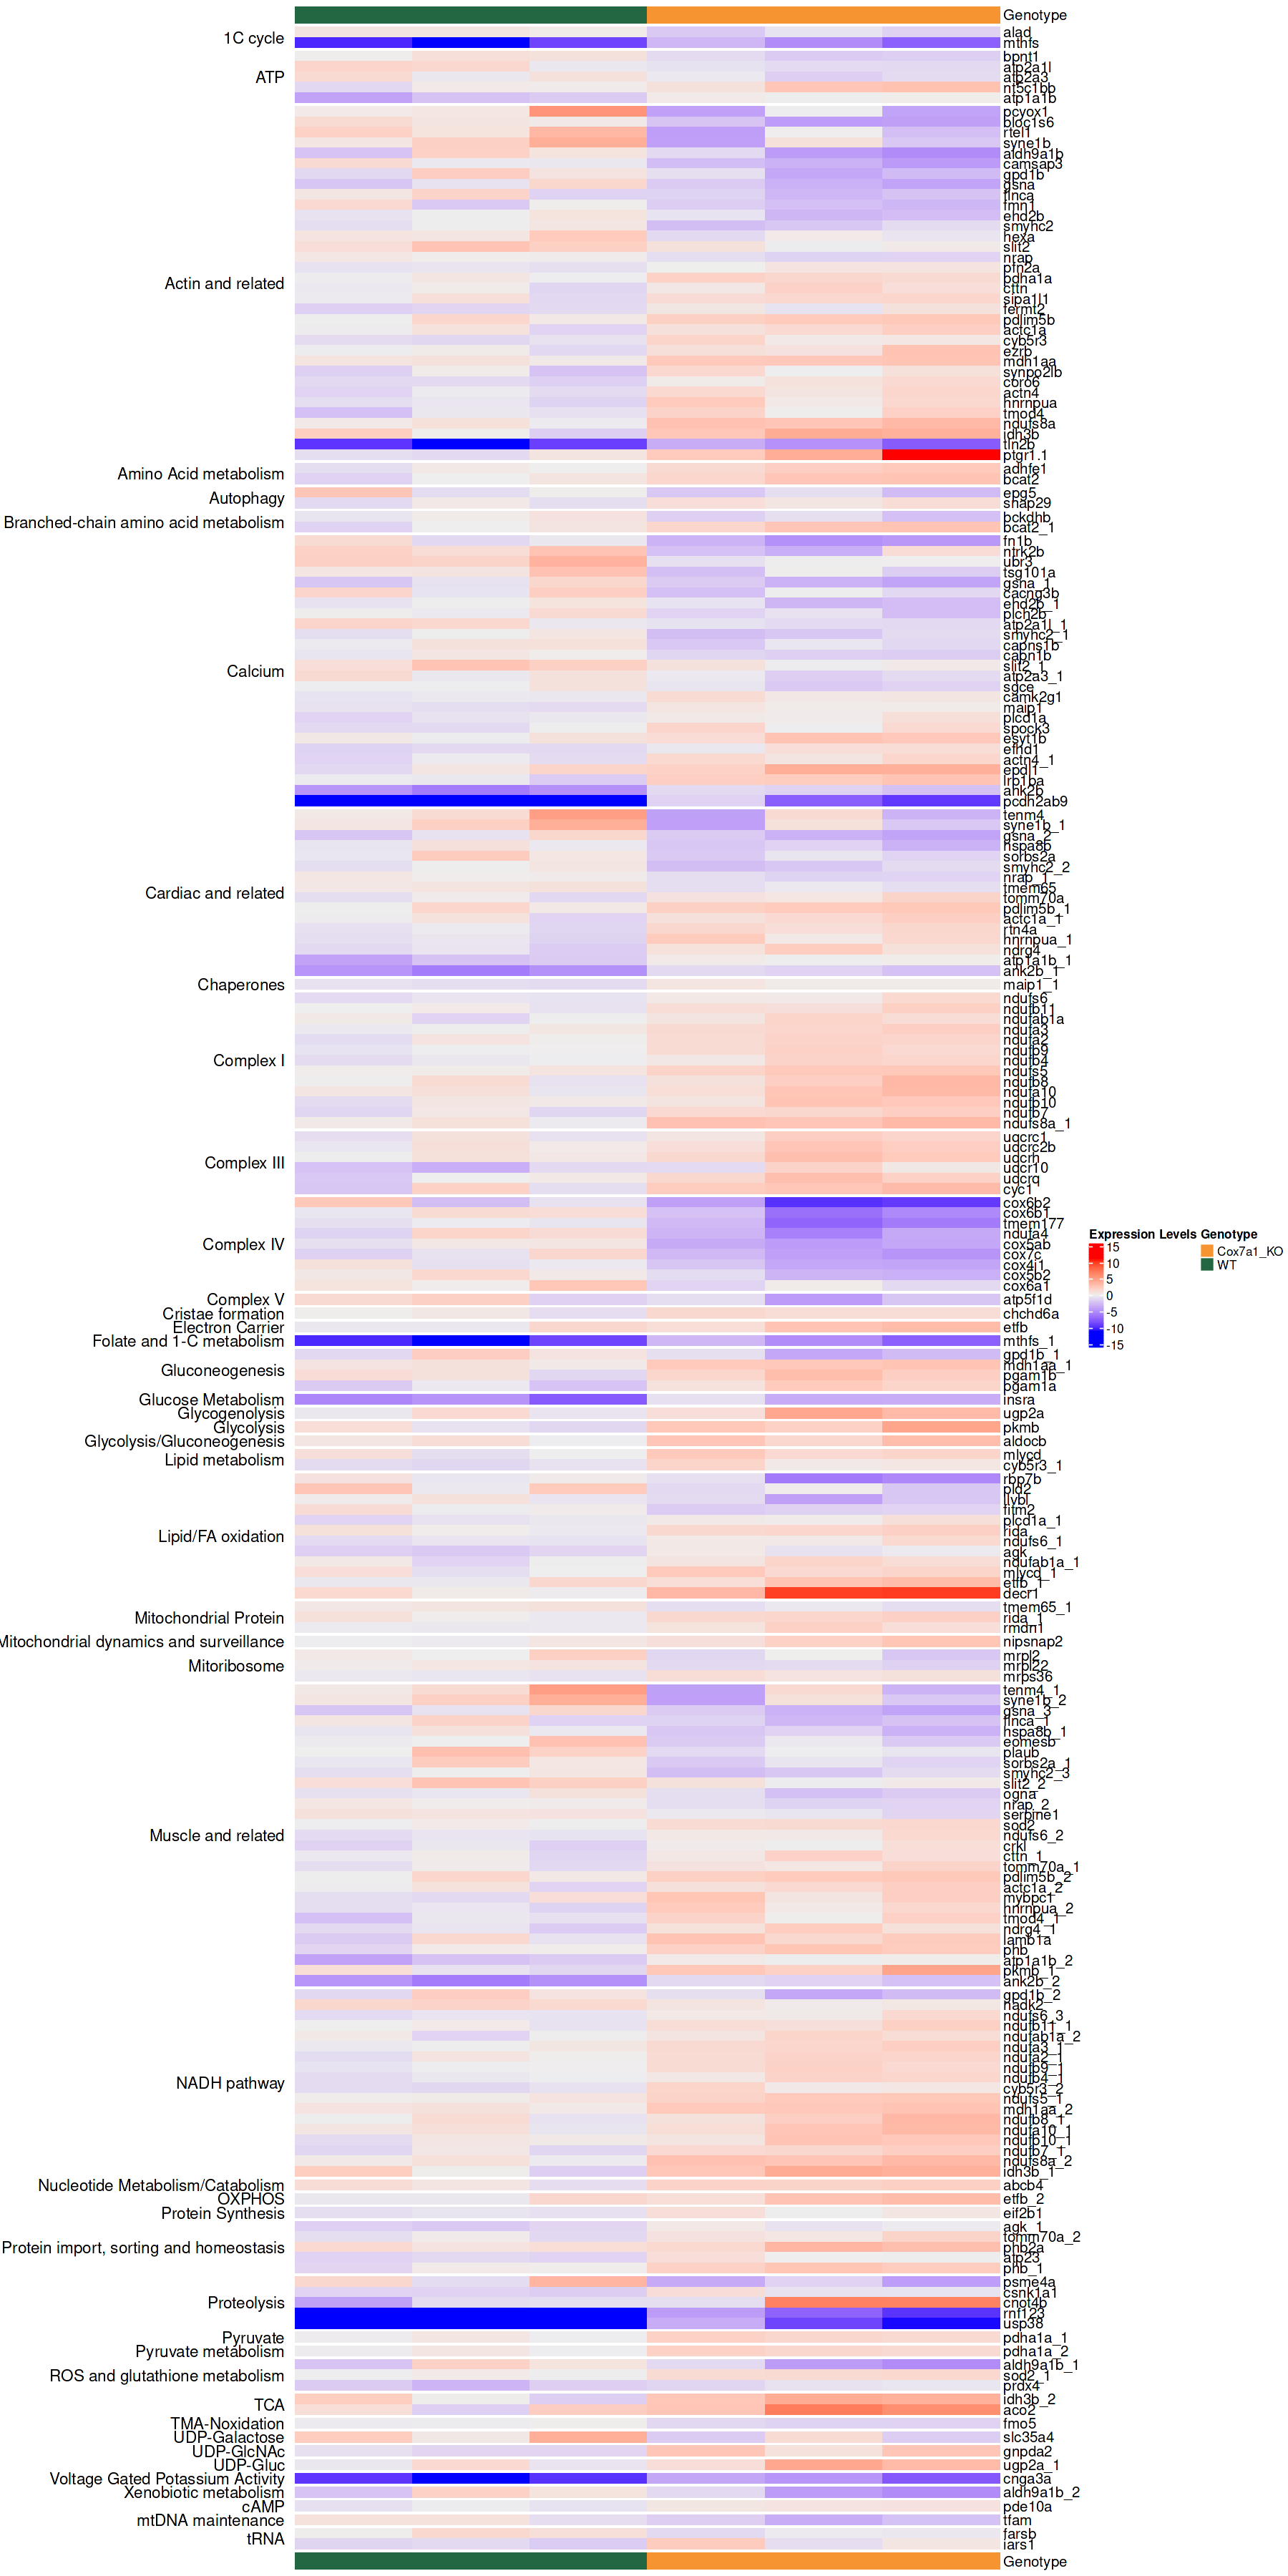

In [26]:
# make bigger graph
options(repr.plot.width=15, repr.plot.height=30)
ha = HeatmapAnnotation(
    Genotype = rep(c("WT","Cox7a1_KO" ), each=3), 
    col = list(Genotype = c(
                            # "WT"=paletteer::paletteer_d("calecopal::arbutus", n=2)[1],
                            "WT"="#226741",
                            # "Cox7a1_KO"=paletteer::paletteer_d("calecopal::arbutus", n=2)[2])
                            "Cox7a1_KO"="#f69431")
                
               )
)

Heatmap(heatmap_mat, name="Expression Levels", 
 cluster_columns = FALSE,  
 cluster_rows = FALSE,  
row_dend_width = unit(0, "cm"), 
# col = viridis::viridis(100, direction = -1),
# col= paletteer::paletteer_c("grDevices::Rocket", n=100, direction=-1),
show_column_names = FALSE,
top_annotation = ha,
row_split = factor(heatmap_list_unique$Pathway, levels = unique(heatmap_list_unique$Pathway)),
row_title_rot = 0, 
bottom_annotation = ha)
dev.copy(pdf, file = "proteomics_n_3_ventricle_technical_avg/ventrilce_heatmap_annotated.pdf", width = 8, height = 30)
dev.off()

In [17]:
heatmap_list_v2 <- read.xlsx("ventricle heat maps_v2.xlsx", sheet = "Mitocarta", colNames = TRUE, detectDates = FALSE, skipEmptyRows = TRUE)
heatmap_list_v2$NOP[is.na(heatmap_list_v2$NOP)] <- 0
# Make the 1st letter of each word in the column OXPHOS.Complex	capital without using stringr::str_to_title
heatmap_list_v2$OXPHOS.Complex <- sapply(strsplit(as.character(heatmap_list_v2$OXPHOS.Complex), " "), function(x) paste(toupper(substring(x, 1,1)), substring(x, 2), sep="", collapse=" "))
# remove trailing and leading spaces from OXPHOS.Complex column
heatmap_list_v2$OXPHOS.Complex <- gsub("^\\s+|\\s+$", "", heatmap_list_v2$OXPHOS.Complex)

# rename gene column to Protein
heatmap_list_v2 <- heatmap_list_v2 %>% dplyr::rename(Protein = gene)
heatmap_list_v2 %>% head
heatmap_list_v2 %>% dim

,Protein,KO1,KO2,KO3,WT1,WT2,WT3,NOP,ko_vs_wt_logFC,OXPHOS.Complex
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,ndufa10,1.0072101,2.650823,3.3550487,0.6169489,0.98814359,-0.45752719,17,1.955172,Complex I
2,ndufa2,1.2584117,1.779872,1.6508282,-0.9543852,0.72168044,0.11206961,8,1.603249,Complex I
3,ndufa3,1.2857025,1.555973,2.0056984,-0.3260931,-0.07399171,0.49444447,1,1.584338,Complex I
4,ndufab1a,0.6335561,1.691166,1.0971000,0.3571941,-1.36667690,-0.04514269,3,1.492149,Complex I
5,uqcr10,-1.0111142,1.754500,0.3664659,-2.2776780,-3.26735167,-1.06381248,3,2.572898,Complex III
6,uqcrc2b,1.0230850,2.646113,2.0944208,-0.4194865,0.99592987,0.28792496,28,1.633084,Complex III


[1] 66 10

In [18]:
# if a protein is duplicated in a OXPHOS.Complex, select the one with the highest NOP
heatmap_list_v2$OXPHOS.Complex %>% unique
heatmap_list_v2$OXPHOS.Complex %>% unique %>% length
heatmap_list_v2_unique <- heatmap_list_v2 %>% group_by(OXPHOS.Complex, Protein) %>% filter(NOP == max(NOP)) %>% ungroup()
# if two proteins are duplicated in a OXPHOS.Complex still and have same NOP then select the top one
heatmap_list_v2_unique <- heatmap_list_v2_unique %>% group_by(OXPHOS.Complex, Protein) %>% filter(ko_vs_wt_logFC == max(ko_vs_wt_logFC)) %>% ungroup()
# if still two proteins are duplicated in a OXPHOS.Complex, then select the first one
heatmap_list_v2_unique <- heatmap_list_v2_unique %>% group_by(OXPHOS.Complex, Protein) %>% filter(row_number() == 1) %>% ungroup()
order_heatmap <- heatmap_list_v2_unique$OXPHOS.Complex %>% unique# %>% dim
unique(heatmap_list_v2_unique$OXPHOS.Complex)
heatmap_list_v2_unique$OXPHOS.Complex %>% unique %>% length
heatmap_list_v2_unique[duplicated(heatmap_list_v2_unique$Protein)|duplicated(heatmap_list_v2_unique$Protein,fromLast = TRUE),] %>% dim


# arrange by first alphabetically OXPHOS.Complex as in order_heatmap and then by log2fc
heatmap_list_v2_unique <- heatmap_list_v2_unique %>% arrange(factor(OXPHOS.Complex, levels = order_heatmap), ko_vs_wt_logFC)



# heatmap_list_v2_unique <- heatmap_list_v2_unique %>% arrange(ko_vs_wt_logFC)



heatmap_list_v2_unique$unique_rownames <- make.unique(heatmap_list_v2_unique$Protein,sep="_")
heatmap_list_v2_unique <-heatmap_list_v2_unique %>%  dplyr::select("unique_rownames", everything())
heatmap_list_v2_unique %>% head
# make a matrix with the unique proteins
heatmap_mat_v2 <- heatmap_list_v2_unique %>% as.data.frame()
rownames(heatmap_mat_v2) <- heatmap_list_v2_unique$unique_rownames
heatmap_mat_v2 <- heatmap_mat_v2 %>% dplyr::select(-unique_rownames, -Protein, -OXPHOS.Complex, -NOP,	-ko_vs_wt_logFC)



# make all columns numeric
heatmap_mat_v2 <- heatmap_mat_v2 %>% mutate_all(as.numeric)
heatmap_mat_v2 <- heatmap_mat_v2 %>% dplyr::select(contains("WT"), contains("KO"))
heatmap_mat_v2 <- as.matrix(heatmap_mat_v2)
heatmap_mat_v2 %>% head
# make columns WT and then KO


# heatmap_mat_v2 %>% head

[1] "Complex I"                              
 [2] "Complex III"                            
 [3] "Complex IV"                             
 [4] "Complex V"                              
 [5] "Cristae Formation"                      
 [6] "Fatty Acid Oxidation"                   
 [7] "Folate And 1 Carbon Cycle"              
 [8] "Lipid Metabolism"                       
 [9] "Mitoribosome"                           
[10] "MtDNA Maintenance"                      
[11] "NAD Biosynthesis And Metabolism"        
[12] "Pyruvate Metabolism"                    
[13] "ROS And Glutathione Metabolism"         
[14] "TCA Cycle"                              
[15] "Xenobiotic Metabolism"                  
[16] "Mitochondrial Protein"                  
[17] "Amino Acid Metabolism"                  
[18] "Branched-chain Amino Acid Metabolism"   
[19] "Chaperones"                             
[20] "Mitochondrial Dynamics And Surveillance"
[21] "Autophagy"                              
[22] "Mitochondrial Ribosome"                 
[23] "Protein Import"                         
[24] "ROS/Glulutathione Metabolism"

[1] 24

[1] "Complex I"                              
 [2] "Complex III"                            
 [3] "Complex IV"                             
 [4] "Complex V"                              
 [5] "Cristae Formation"                      
 [6] "Fatty Acid Oxidation"                   
 [7] "Folate And 1 Carbon Cycle"              
 [8] "Lipid Metabolism"                       
 [9] "Mitoribosome"                           
[10] "MtDNA Maintenance"                      
[11] "NAD Biosynthesis And Metabolism"        
[12] "Pyruvate Metabolism"                    
[13] "ROS And Glutathione Metabolism"         
[14] "TCA Cycle"                              
[15] "Xenobiotic Metabolism"                  
[16] "Mitochondrial Protein"                  
[17] "Amino Acid Metabolism"                  
[18] "Branched-chain Amino Acid Metabolism"   
[19] "Chaperones"                             
[20] "Mitochondrial Dynamics And Surveillance"
[21] "Autophagy"                              
[22] "Mitochondrial Ribosome"                 
[23] "Protein Import"                         
[24] "ROS/Glulutathione Metabolism"

[1] 24

[1]  2 10

unique_rownames,Protein,KO1,KO2,KO3,WT1,WT2,WT3,NOP,ko_vs_wt_logFC,OXPHOS.Complex
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ndufs6,ndufs6,0.3872960,0.3114135,1.403355,-1.01001485,-0.50885979,-0.56699868,3,1.395979,Complex I
ndufb11,ndufb11,1.1220066,0.9514735,1.959929,-0.00932997,0.29319824,-0.61283752,1,1.454126,Complex I
ndufab1a,ndufab1a,0.6335561,1.6911659,1.097100,0.35719412,-1.36667690,-0.04514269,3,1.492149,Complex I
ndufa3,ndufa3,1.2857025,1.5559725,2.005698,-0.32609309,-0.07399171,0.49444447,1,1.584338,Complex I
ndufa2,ndufa2,1.2584117,1.7798722,1.650828,-0.95438521,0.72168044,0.11206961,8,1.603249,Complex I
ndufb9,ndufb9,1.2566677,1.8606450,1.342288,-0.54845782,-0.10723745,0.06709887,6,1.682732,Complex I


,WT1,WT2,WT3,KO1,KO2,KO3
ndufs6,-1.01001485,-0.50885979,-0.56699868,0.3872960,0.3114135,1.403355
ndufb11,-0.00932997,0.29319824,-0.61283752,1.1220066,0.9514735,1.959929
ndufab1a,0.35719412,-1.36667690,-0.04514269,0.6335561,1.6911659,1.097100
ndufa3,-0.32609309,-0.07399171,0.49444447,1.2857025,1.5559725,2.005698
ndufa2,-0.95438521,0.72168044,0.11206961,1.2584117,1.7798722,1.650828
ndufb9,-0.54845782,-0.10723745,0.06709887,1.2566677,1.8606450,1.342288


pdf 
  3

png 
  2

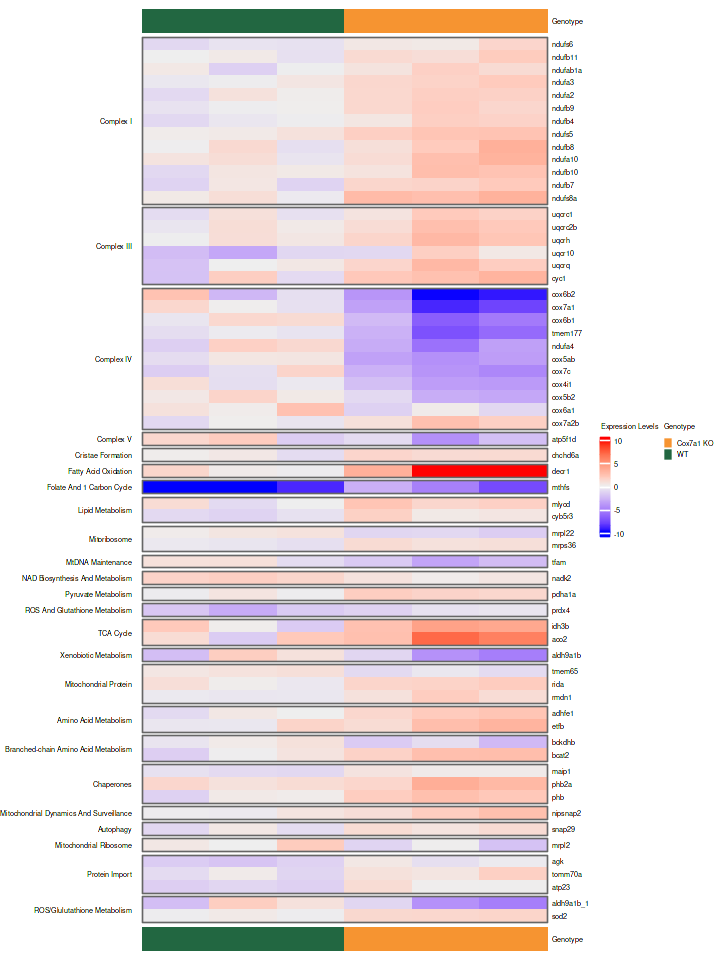

In [19]:
# make bigger graph
options(repr.plot.width=6, repr.plot.height=8)
ha = HeatmapAnnotation(
    Genotype = rep(c("WT","Cox7a1 KO" ), each=3), 
    col = list(Genotype = c(
                # "WT"=paletteer::paletteer_d("calecopal::arbutus", n=2)[1],
                            "WT"="#226741",
                            # "Cox7a1_KO"=paletteer::paletteer_d("calecopal::arbutus", n=2)[2])
                            "Cox7a1 KO"="#f69431")
                
               ),
               # change font size of the annotation
                annotation_name_gp = grid::gpar(fontsize = 4),
                annotation_legend_param = list(
        # title = "Expression Levels",
        title_gp = gpar(fontsize = 4),
        labels_gp = gpar(fontsize = 4),
        grid_width	= unit(5,"point"),
        grid_height	= unit(5,"point")),
        height=unit(0,"point")
        )

ComplexHeatmap::Heatmap(heatmap_mat_v2, name="Expression Levels", 
 cluster_columns = FALSE,  
 cluster_rows = FALSE,  
row_dend_width = unit(0, "point"), 
# col = viridis::viridis(100, direction = -1),
# col= paletteer::paletteer_c("grDevices::Rocket", n=100, direction=-1),
show_column_names = FALSE,
top_annotation = ha,
row_split = factor(heatmap_list_v2_unique$OXPHOS.Complex, levels = unique(heatmap_list_v2_unique$OXPHOS.Complex)),
gap=unit(2, "point"),
border= TRUE,
 border_gp = gpar(col = "grey40"),
row_title_gp = gpar(fontsize = 4), # change row split font size
row_title_rot = 0, 
bottom_annotation = ha,
heatmap_legend_param = list(
        title = "Expression Levels",
        title_gp = gpar(fontsize = 4),
        labels_gp = gpar(fontsize = 4),
        grid_width	= unit(5, "point"),
        grid_height	= unit(5, "point")
    ),
row_names_gp = grid::gpar(fontsize = 4))

dev.copy(pdf, file = "proteomics_n_3_ventricle_technical_avg/ventrilce_heatmap_annotated_v5_mitocarta.pdf", width = 3, height = 4.5)
dev.off()

In [20]:
heatmap_list_v2_others <- read.xlsx("ventricle heat maps_v2.xlsx", sheet = "others", colNames = TRUE, detectDates = FALSE, skipEmptyRows = TRUE)
heatmap_list_v2_others$NOP[is.na(heatmap_list_v2_others$NOP)] <- 0

# Make the 1st letter of each word in the column OXPHOS.Complex	capital without using stringr::str_to_title
heatmap_list_v2_others$OXPHOS.Complex <- sapply(strsplit(as.character(heatmap_list_v2_others$OXPHOS.Complex), " "), function(x) paste(toupper(substring(x, 1,1)), substring(x, 2), sep="", collapse=" "))

# remove trailing and leading spaces from OXPHOS.Complex column
heatmap_list_v2_others$OXPHOS.Complex <- gsub("^\\s+|\\s+$", "", heatmap_list_v2_others$OXPHOS.Complex)

# rename gene column to Protein
heatmap_list_v2_others <- heatmap_list_v2_others %>% dplyr::rename(Protein = gene)
heatmap_list_v2_others %>% head
heatmap_list_v2_others %>% dim

,Protein,KO1,KO2,KO3,WT1,WT2,WT3,NOP,ko_vs_wt_logFC,OXPHOS.Complex,Label
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,alad,-1.8937150,-0.58330430,-1.4975788,0.672693,0.6583896,0.2379190,10,-1.847867,1 Carbon Cycle,Metabolism
2,mthfs,-2.8691737,-5.07133932,-7.4903233,-10.143908,-12.7743762,-8.8958321,1,5.461093,1 Carbon Cycle,Metabolism
3,bcat2,1.5979720,2.63781594,2.7348600,-1.437596,-0.0244880,0.6275970,16,2.601712,Amino Acid Metabolism,Metabolism
4,ALDH9A1,-1.0758477,-4.27148319,-5.1340732,-2.182588,1.8254340,0.7438257,6,-3.622692,Aldehydes/carnithin Metabolism,Metabolism
5,atp1a1b,0.2911286,-0.07343499,0.1624315,-3.976195,-2.2186918,-1.8081526,1,2.794388,ATP Synthesis And Related,Metabolism
6,atp2a1l,-0.6378300,-1.01123993,-1.0630356,1.619401,1.4437790,-0.3482483,22,-1.809012,ATP Synthesis And Related,Metabolism


[1] 178  11

In [21]:
# if a protein is duplicated in a OXPHOS.Complex, select the one with the highest NOP
heatmap_list_v2_others$OXPHOS.Complex %>% unique
heatmap_list_v2_others$OXPHOS.Complex %>% unique %>% length
heatmap_list_v2_others_unique <- heatmap_list_v2_others %>% group_by(OXPHOS.Complex, Protein) %>% filter(NOP == max(NOP)) %>% ungroup()
# if two proteins are duplicated in a OXPHOS.Complex still and have same NOP then select the top one
heatmap_list_v2_others_unique <- heatmap_list_v2_others_unique %>% group_by(OXPHOS.Complex, Protein) %>% filter(ko_vs_wt_logFC == max(ko_vs_wt_logFC)) %>% ungroup()
# if still two proteins are duplicated in a OXPHOS.Complex, then select the first one
heatmap_list_v2_others_unique <- heatmap_list_v2_others_unique %>% group_by(OXPHOS.Complex, Protein) %>% filter(row_number() == 1) %>% ungroup()
order_heatmap <- heatmap_list_v2_others_unique$OXPHOS.Complex %>% unique# %>% dim
unique(heatmap_list_v2_others_unique$OXPHOS.Complex)
heatmap_list_v2_others_unique$OXPHOS.Complex %>% unique %>% length
heatmap_list_v2_others_unique[duplicated(heatmap_list_v2_others_unique$Protein)|duplicated(heatmap_list_v2_others_unique$Protein,fromLast = TRUE),] %>% dim


# arrange by first alphabetically OXPHOS.Complex as in order_heatmap and then by log2fc
heatmap_list_v2_others_unique <- heatmap_list_v2_others_unique %>% arrange(factor(OXPHOS.Complex, levels = order_heatmap), ko_vs_wt_logFC)



# heatmap_list_v2_others_unique <- heatmap_list_v2_others_unique %>% arrange(ko_vs_wt_logFC)



heatmap_list_v2_others_unique$unique_rownames <- make.unique(heatmap_list_v2_others_unique$Protein,sep="_")
heatmap_list_v2_others_unique <-heatmap_list_v2_others_unique %>%  dplyr::select("unique_rownames", everything())
heatmap_list_v2_others_unique %>% head
# make a matrix with the unique proteins
heatmap_mat_v2_others <- heatmap_list_v2_others_unique %>% as.data.frame()
rownames(heatmap_mat_v2_others) <- heatmap_list_v2_others_unique$unique_rownames
heatmap_mat_v2_others <- heatmap_mat_v2_others %>% dplyr::select(-unique_rownames, -Protein, -OXPHOS.Complex, -NOP,	-ko_vs_wt_logFC,	-Label)



# make all columns numeric
heatmap_mat_v2_others <- heatmap_mat_v2_others %>% mutate_all(as.numeric)
heatmap_mat_v2_others <- heatmap_mat_v2_others %>% dplyr::select(contains("WT"), contains("KO"))
heatmap_mat_v2_others <- as.matrix(heatmap_mat_v2_others)
# make columns WT and then KO


# heatmap_mat_v2_others %>% head

[1] "1 Carbon Cycle"                     "Amino Acid Metabolism"             
 [3] "Aldehydes/carnithin Metabolism"     "ATP Synthesis And Related"         
 [5] "Autophagy"                          "CAMP Pathway"                      
 [7] "Gluconeogenesis"                    "Glucose Uptake"                    
 [9] "Glycogenolysis"                     "Glycolysis"                        
[11] "Lipid/Fatty Acid Oxidation"         "NADH Pathway"                      
[13] "Nucleotide Metabolism"              "OXPHOS"                            
[15] "Protein Synthesis"                  "Pyruvate"                          
[17] "TCA"                                "TMA N-Oxidation"                   
[19] "TRNA"                               "UDP Metabolism Related"            
[21] "Actin And Related"                  "Cardiac"                           
[23] "Muscle"                             "Proteosomal Degradation/Protelysis"
[25] "Calcium Signalling And Related"

[1] 25

[1] "1 Carbon Cycle"                     "Amino Acid Metabolism"             
 [3] "Aldehydes/carnithin Metabolism"     "ATP Synthesis And Related"         
 [5] "Autophagy"                          "CAMP Pathway"                      
 [7] "Gluconeogenesis"                    "Glucose Uptake"                    
 [9] "Glycogenolysis"                     "Glycolysis"                        
[11] "Lipid/Fatty Acid Oxidation"         "NADH Pathway"                      
[13] "Nucleotide Metabolism"              "OXPHOS"                            
[15] "Protein Synthesis"                  "Pyruvate"                          
[17] "TCA"                                "TMA N-Oxidation"                   
[19] "TRNA"                               "UDP Metabolism Related"            
[21] "Actin And Related"                  "Cardiac"                           
[23] "Muscle"                             "Proteosomal Degradation/Protelysis"
[25] "Calcium Signalling And Related"

[1] 25

[1] 88 11

unique_rownames,Protein,KO1,KO2,KO3,WT1,WT2,WT3,NOP,ko_vs_wt_logFC,OXPHOS.Complex,Label
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
alad,alad,-1.8937150,-0.5833043,-1.497579,0.67269299,0.6583896,0.2379190,10,-1.847867,1 Carbon Cycle,Metabolism
mthfs,mthfs,-2.8691737,-5.0713393,-7.490323,-10.14390754,-12.7743762,-8.8958321,1,5.461093,1 Carbon Cycle,Metabolism
ilvbl,ilvbl,-1.0025913,-4.0601677,-2.013272,0.20263726,0.8198455,-0.4977886,2,-2.533575,Amino Acid Metabolism,Metabolism
bcat2,bcat2,1.5979720,2.6378159,2.734860,-1.43759576,-0.0244880,0.6275970,16,2.601712,Amino Acid Metabolism,Metabolism
ALDH9A1,ALDH9A1,-1.0758477,-4.2714832,-5.134073,-2.18258779,1.8254340,0.7438257,6,-3.622692,Aldehydes/carnithin Metabolism,Metabolism
bpnt1,bpnt1,-0.9682324,-1.8353367,-1.624051,0.07364603,0.9653733,0.8287821,4,-2.098474,ATP Synthesis And Related,Metabolism


In [22]:
unique(heatmap_list_v2_unique$OXPHOS.Complex)

[1] "Complex I"                              
 [2] "Complex III"                            
 [3] "Complex IV"                             
 [4] "Complex V"                              
 [5] "Cristae Formation"                      
 [6] "Fatty Acid Oxidation"                   
 [7] "Folate And 1 Carbon Cycle"              
 [8] "Lipid Metabolism"                       
 [9] "Mitoribosome"                           
[10] "MtDNA Maintenance"                      
[11] "NAD Biosynthesis And Metabolism"        
[12] "Pyruvate Metabolism"                    
[13] "ROS And Glutathione Metabolism"         
[14] "TCA Cycle"                              
[15] "Xenobiotic Metabolism"                  
[16] "Mitochondrial Protein"                  
[17] "Amino Acid Metabolism"                  
[18] "Branched-chain Amino Acid Metabolism"   
[19] "Chaperones"                             
[20] "Mitochondrial Dynamics And Surveillance"
[21] "Autophagy"                              
[22] "Mitochondrial Ribosome"                 
[23] "Protein Import"                         
[24] "ROS/Glulutathione Metabolism"

pdf 
  3

png 
  2

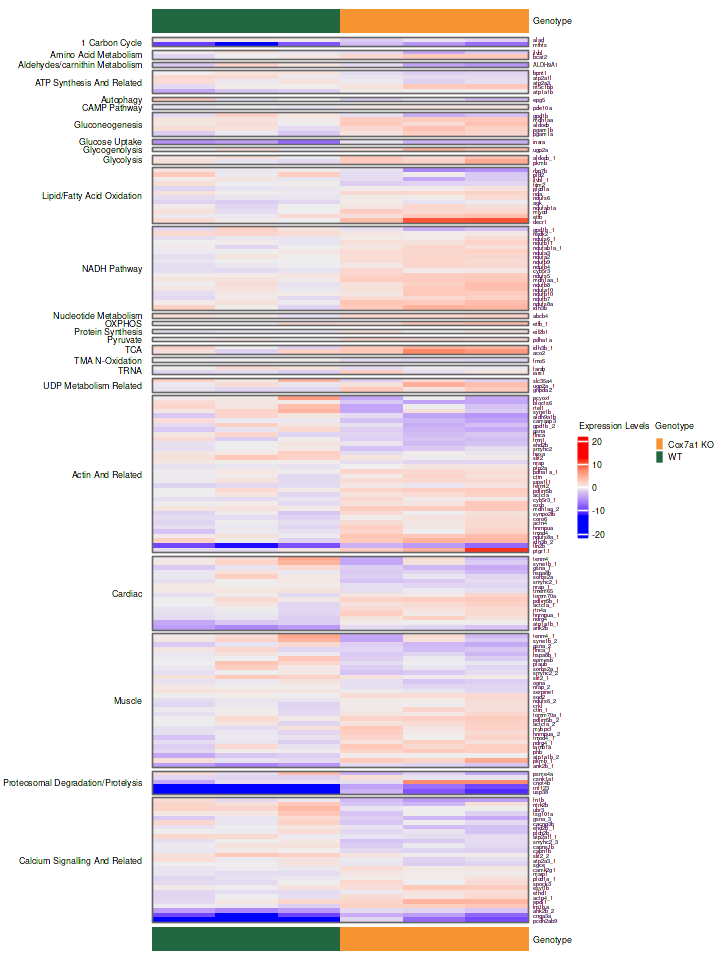

In [23]:
# make bigger graph
options(repr.plot.width=6, repr.plot.height=8)
ha = HeatmapAnnotation(
    Genotype = rep(c("WT","Cox7a1 KO" ), each=3), 
    col = list(Genotype = c(
                # "WT"=paletteer::paletteer_d("calecopal::arbutus", n=2)[1],
                            "WT"="#226741",
                            # "Cox7a1_KO"=paletteer::paletteer_d("calecopal::arbutus", n=2)[2])
                            "Cox7a1 KO"="#f69431")
                
               ),
               # change font size of the annotation
                annotation_name_gp = grid::gpar(fontsize = 5),
                annotation_legend_param = list(
        # title = "Expression Levels",
        title_gp = gpar(fontsize = 5),
        labels_gp = gpar(fontsize = 5),
        grid_width	= unit(5,"point"),
        grid_height	= unit(5,"point")

        
))

Heatmap(heatmap_mat_v2_others, name="Expression Levels", 
 cluster_columns = FALSE,  
 cluster_rows = FALSE,  
row_dend_width = unit(0, "cm"), 
# col = viridis::viridis(100, direction = -1),
# col= paletteer::paletteer_c("grDevices::Rocket", n=100, direction=-1),
show_column_names = FALSE,
top_annotation = ha,
row_split = factor(heatmap_list_v2_others_unique$OXPHOS.Complex, levels = unique(heatmap_list_v2_others_unique$OXPHOS.Complex)),
gap=unit(2, "point"),
border= TRUE,
 border_gp = gpar(col = "grey40"),
row_title_gp = gpar(fontsize = 5), # change row split font size
row_title_rot = 0, 
bottom_annotation = ha,
heatmap_legend_param = list(
        title = "Expression Levels",
        title_gp = gpar(fontsize = 5),
        labels_gp = gpar(fontsize = 5),
        grid_width	= unit(5,"point"),
        grid_height	= unit(5,"point")
    ),
row_names_gp = grid::gpar(fontsize = 3))

# save plot as pdf
dev.copy(pdf, file = "proteomics_n_3_ventricle_technical_avg/ventrilce_heatmap_annotated_v4_others.pdf", width = 3, height = 7.5)
dev.off()

# Volcano plots

In [31]:
description_df_mouse_zf %>% colnames
description_df_mouse_zf_volcano <- description_df_mouse_zf %>% dplyr::select(gene,  KO1, KO2, KO3, WT1, WT2,WT3, ko_vs_wt_P.Value, ko_vs_wt_logFC, NOP)
# rename ko_vs_wt_P.Value	to pval ko_vs_wt_logFC to logFoldChange
description_df_mouse_zf_volcano <- description_df_mouse_zf_volcano %>% dplyr::rename(pval = ko_vs_wt_P.Value, logFoldChange = ko_vs_wt_logFC)
description_df_mouse_zf_volcano <- description_df_mouse_zf_volcano %>% distinct
description_df_mouse_zf_volcano <- description_df_mouse_zf_volcano %>% group_by(gene) %>% filter(NOP == max(NOP)) %>% ungroup()
description_df_mouse_zf_volcano <- description_df_mouse_zf_volcano %>% group_by(gene) %>% filter(logFoldChange == max(logFoldChange)) %>% ungroup()
description_df_mouse_zf_volcano %>% colnames()
description_df_mouse_zf_volcano %>% dim()
description_df_mouse_zf_volcano %>% arrange(desc(abs(logFoldChange))) %>%  head()


[1] "gene"                             "gene_mouse"                      
 [3] "protein"                          "KO1"                             
 [5] "KO2"                              "KO3"                             
 [7] "WT1"                              "WT2"                             
 [9] "WT3"                              "NOP"                             
[11] "ko_vs_wt_logFC"                   "ko_vs_wt_P.Value"                
[13] "ko_vs_wt_adj.P.Val"               "gene_full_name_zf"               
[15] "GO_description_zf"                "associated_phenotype_zf"         
[17] "GO_name_zf"                       "GO_family_zf"                    
[19] "gene_full_name_mouse"             "GO_description_mouse"            
[21] "associated_phenotype_mouse"       "GO_name_mouse"                   
[23] "GO_family_mouse"                  "Description"                     
[25] "MitoCarta3.0_SubMitoLocalization" "MitoCarta3.0_MitoPathways"       
[27] "confirmation_status_muscle"       "confirmation_status_ventricle"   
[29] "info_genecards_uniprot_nadia"

[1] "gene"          "KO1"           "KO2"           "KO3"          
 [5] "WT1"           "WT2"           "WT3"           "pval"         
 [9] "logFoldChange" "NOP"

[1] 4040   10

gene,KO1,KO2,KO3,WT1,WT2,WT3,pval,logFoldChange,NOP
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ass1,-5.153913,-13.878287,-10.127414,3.102007,1.614356,-2.870240,0.002746317,-10.335246,10
ORFNames=zgc:162509 {ECO:0000313|ZFIN:ZDB-GENE-050809-100};,2.914659,14.445267,8.732459,-1.426478,-4.607301,1.159704,0.007065737,10.322153,9
osm,3.793709,14.891488,9.918484,-6.357533,3.016443,1.058804,0.013997310,10.295322,1
usp38,-3.395814,-8.901054,-11.060259,-15.078312,-20.319190,-14.655742,0.004521568,8.898706,1
myhz1.2,-4.961302,-5.220350,-8.114330,18.489280,-6.904081,-4.711620,0.207584538,-8.389853,61
ba1,-5.602232,-8.497147,-13.872898,8.516233,-6.312119,-6.031472,0.086368713,-8.048306,3


In [32]:
# replace gene ORFNames=zgc:162509 {ECO:0000313|ZFIN:ZDB-GENE-050809-100}; with zgc:162509\
description_df_mouse_zf_volcano$gene[description_df_mouse_zf_volcano$gene=="ORFNames=zgc:162509 {ECO:0000313|ZFIN:ZDB-GENE-050809-100};"] <- "zgc:162509" 
description_df_mouse_zf_volcano$gene[description_df_mouse_zf_volcano$gene =="ORFNames=zgc:153921 {ECO:0000313|ZFIN:ZDB-GENE-060929-816};"] <- "zgc:153921"


In [86]:
# make a volcano plot for description_df_mouse_zf only for AKO and AWT columns 
####################
#                  #
# VOLCANO FUNCTION #
#                  #
####################
require(ggplot2)
require(ggrepel)
require(clusterProfiler)
require(tidyverse)

draw_volcano<- function(fileinput, title) {
  # read input file
  # drawing plots
  ggplot(data =fileinput , aes(x = logFoldChange, y = -log10(pval))) +
    # draw lines
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", col = "gray50") +
    geom_hline(yintercept = -log10(0.05), linetype = "dotted", col = "gray50") +
    geom_vline(xintercept = 0, linetype = "dashed")+
    # draw points
    geom_point(x = fileinput$logFoldChange, y = -log10(fileinput$pval),alpha = 0.5, size = 2,color="grey51") +
    # draw coloured points
    geom_point(data = fileinput[which(fileinput$pval < 0.05 & fileinput$logFoldChange < -1),],
              aes(x=logFoldChange, y = -log10(pval)), shape = 21, color = 
              # "#226741", fill = "#226741",
               "green", fill = "green",
               alpha = 0.8, size = 2) +
    geom_point(data = fileinput[which(fileinput$pval < 0.05 & fileinput$logFoldChange > 1),],
               aes(x=logFoldChange, y = -log10(pval)), shape = 21, color = 
              #  "#f69431", fill = "#f69431",
               "magenta", fill = "magenta",alpha = 0.8, size = 2) +
    # x axis scale
    scale_x_continuous(breaks = seq(round(min(fileinput$logFoldChange)- 0.5),round(max(fileinput$logFoldChange)+ 0.5),by = 1), limits = c(round(min(fileinput$logFoldChange)-1),round(max(fileinput$logFoldChange)+1))) + xlab("logFoldChange") + #ylab("-Log10(p.value)") +
    
    scale_y_continuous(breaks = seq(0,round(-log10(min(fileinput$pval))+1),by = 4), limits = c(0,round(-log10(min(fileinput$pval))+1))) + ylab("-Log10(pvalue)") + # ylab("-log10(p.value)")+
    
    # set title
    ggtitle(title)+
    # x and y axis limits
    # black and white theme
    theme_bw() +
    # center title
    theme(plot.title = element_text(hjust = 0.5), axis.text = element_text(size = 10), axis.title.x = element_text(size = 10),
          axis.title.y = element_text(size = 10))
}
###################


gene,KO1,KO2,KO3,WT1,WT2,WT3,pval,logFoldChange,NOP
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
zgc:162509,2.9146591,14.4452666,8.732459,-1.4264778,-4.6073007,1.1597040,0.0070657368,10.322153,9
osm,3.7937086,14.8914883,9.918484,-6.3575331,3.0164434,1.0588039,0.0139973098,10.295322,1
usp38,-3.3958137,-8.9010539,-11.060259,-15.0783124,-20.3191902,-14.6557418,0.0045215684,8.898706,1
pcdh2ab9,-1.4559199,-7.5875340,-9.431745,-13.7700134,-16.1866828,-12.5094588,0.0047960337,7.996985,1
rnf123,-4.3013214,-7.3144955,-9.668344,-14.9984992,-16.1921003,-12.7682378,0.0010279893,7.558226,1
LOC110437804,-1.5053579,-6.1424277,-6.791214,-12.1810727,-13.2783436,-11.4169663,0.0008140518,7.479128,1
ift74,-5.7593055,-9.5788620,-10.266730,-14.7862093,-17.7906143,-15.3345319,0.0006750930,7.435486,1
decr1,3.4801039,9.9239165,10.096107,1.3792279,0.2121305,-0.1296590,0.0031835445,7.346143,14
cnga3a,-3.7538779,-4.6571801,-7.886207,-9.5688260,-18.1980418,-9.7773900,0.0182288365,7.082331,1


pdf 
  3

png 
  2

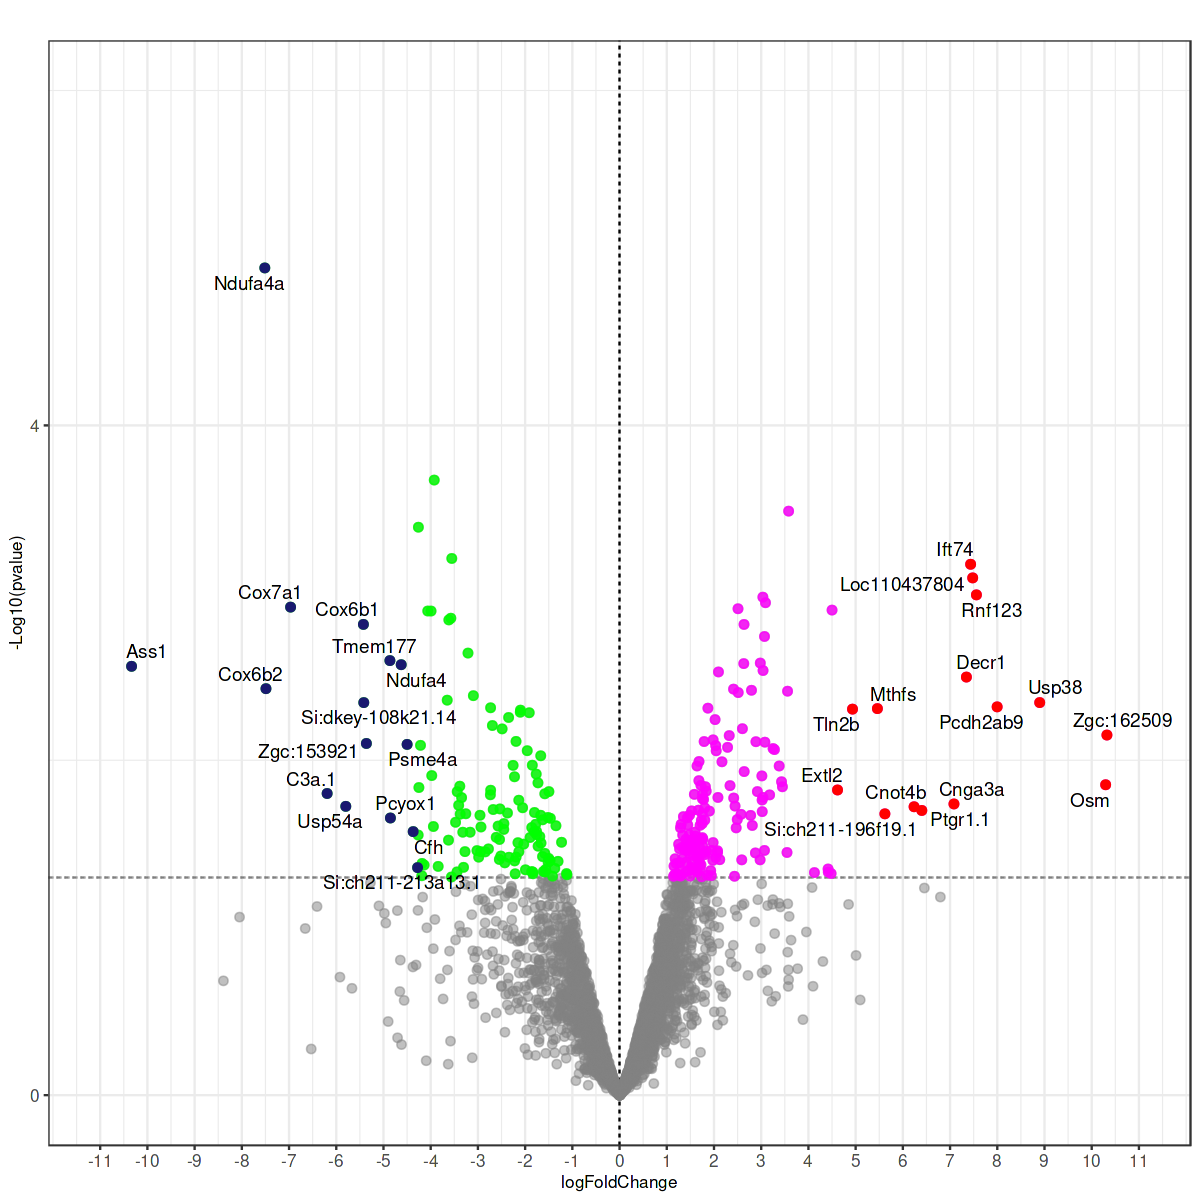

In [87]:

# change graph size
options(repr.plot.width=10, repr.plot.height=10)
b = draw_volcano(description_df_mouse_zf_volcano,"")
# print(b)
# #Set genes for marking 
# take top and bottom 20 genes according to logFoldChange
top_20_up <-  description_df_mouse_zf_volcano %>% arrange(desc(logFoldChange)) %>% filter(pval<0.05) %>% head(15)
top_20_up
top_20_down  <- description_df_mouse_zf_volcano %>% arrange(logFoldChange) %>% filter(pval<0.05) %>% head(15)
# top_20_down
top_20_updown <- rbind(top_20_up,top_20_down)
# top_20_updown


require(ggrepel)
#Paint the genes in the plot
c= b + geom_point(data=description_df_mouse_zf_volcano[description_df_mouse_zf_volcano$gene%in%top_20_updown$gene,],color=ifelse(description_df_mouse_zf_volcano[description_df_mouse_zf_volcano$gene%in%top_20_updown$gene,]$logFoldChange > 0,"red","midnightblue"),size=2) +
  geom_text_repel(data = description_df_mouse_zf_volcano[description_df_mouse_zf_volcano$gene%in%top_20_updown$gene,],aes(label=str_to_title(description_df_mouse_zf_volcano[description_df_mouse_zf_volcano$gene%in%top_20_updown$gene,]$gene),
  ),#nudge_x = 0.5,
# nudge_y = 0.25,
# segment.size = 1
)
c


# #Save the plot
dev.copy(
  pdf,
  file = "proteomics_n_3_ventricle_technical_avg/ventricle_volcano_magenta_green.pdf",
  width = 10,
  height = 10
)
dev.off ()

In [5]:
description_df_mouse_zf%>% filter(gene=="cox7a1")

gene,gene_mouse,protein,KO1,KO2,KO3,WT1,WT2,WT3,NOP,⋯,GO_description_mouse,associated_phenotype_mouse,GO_name_mouse,GO_family_mouse,Description,MitoCarta3.0_SubMitoLocalization,MitoCarta3.0_MitoPathways,confirmation_status_muscle,confirmation_status_ventricle,info_genecards_uniprot_nadia
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
cox7a1,NA,E9QDH1,-3.503921,-8.936727,-7.756023,1.290831,0.04860092,-0.6341581,2,⋯,NA,NA,NA,NA,NA,NA,NA,,,


# Save Rdata and write the session info

In [80]:
save.image(file = "./ventricle_proteomics_n_3_12122023.RData")

In [3]:
load("./ventricle_proteomics_n_3.RData")

In [4]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 22.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.10.0 
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.10.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_CH.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=de_CH.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=de_CH.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_CH.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Zurich
tzcode source: system (glibc)

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggVennDiagram_1.2.3   limma_3.56.2          openxlsx_4.2.5.2     
 [4] paletteer_1.5.0       ComplexHeatmap_2.16.0 org.Hs.eg.db_3.17.0  
 [7] org.Mm.eg.db_3.17.0   AnnotationDbi_1.